# Notebooks figures: 
#### 1) F4, S5, S6, S11, S12: Venn diagrams
#### 2) F4, S6, S11: Complementarity bar plots
#### 3) F2, S2, S11: Number of detected genes

# Complementarity analysys

In [6]:
import sys
sys.path.append('../../')
from global_variables import SUBDIR, RUN, WORKSPACE, SUBDIR_CH, RUN_CH, colors_dict, names_dict

In [2]:
import pandas as pd
import math
from matplotlib_venn import venn2, venn3, venn3_circles
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
datasets = f"{WORKSPACE}/projects/clustering_3d/o3d_analysys/datasets/"
input_path = f"{datasets}/input/cancer_202404"
cohort_df = pd.read_csv(f"{input_path}/cohorts.tsv", sep="\t")
intogen_output = f"{datasets}/output/cancer_202404/intogen_output"
genetable_path = f"{WORKSPACE}/projects/clustering_3d/o3d_analysys/o3d_paper/notebooks/0.genetables/results/{SUBDIR}/{RUN}.genetable.tsv"
oncotree_df = pd.read_csv(f"{datasets}/input/cancer_202404/oncotree.tsv", sep="\t")
figures = f"{WORKSPACE}/projects/clustering_3d/o3d_analysys/o3d_paper/figures_and_tables"

genetable = pd.read_csv(genetable_path, sep="\t")
genetable_subset = genetable[genetable["Cohort"].str.startswith("TCGA")]

lst_methods = ["o3d", "hotmaps", "clustl", "smreg", "cbase", "dndscv", "mutpan", "fml"]

# Group cohorts by organ

In [4]:
def get_parent_tissues_dict(lst_tissues, oncotree_df):

    tissue_parent_dict = {}
    upper_ttypes = ["SOLID", "BOWEL", "OTHER", "CANCER", "NON_SOLID", np.nan]
    for tissue in lst_tissues:
        parent = tissue
        while parent not in upper_ttypes:
            if parent not in upper_ttypes:
                if parent not in upper_ttypes:
                    tissue_parent_dict[tissue] = parent
                    parent = oncotree_df[oncotree_df["ID"] == parent].PARENT.values
                    if len(parent) == 0:
                        parent = "OTHER"
                    else:
                        parent = parent[0]

    return tissue_parent_dict

# Get a dict to upper parent tissue for each tissue appearing in our cohorts
cohorts_tissue_parent_dict = get_parent_tissues_dict(cohort_df.CANCER_TYPE.unique(), oncotree_df)

# Get general cancer type for our cohorts
cohort_df["GENERAL_CANCER_TYPE"] = cohort_df.CANCER_TYPE.apply(lambda x: cohorts_tissue_parent_dict[x])
cohort_df

COHORT  CANCER_TYPE PLATFORM  MUTATIONS  SAMPLES  \
0         HARTWIG_WGS_BLCA_2023         BLCA      WGS    5017561      144   
1          HARTWIG_WGS_EGC_2023          EGC      WGS     573540       21   
2          HARTWIG_WGS_LMS_2023          LMS      WGS     339549       43   
3    CBIOP_WGS_STAD_ONCOSG_2018         STAD      WGS     861309      147   
4      CBIOP_WXS_CM_VALLEN_2018          MEL      WXS     132960      151   
..                          ...          ...      ...        ...      ...   
266               TCGA_WXS_PRCC         PRCC      WXS      34566      276   
267               TCGA_WXS_PRAD         PRAD      WXS      34239      494   
268             TCGA_WXS_PLMESO       PLMESO      WXS       3980       82   
269        TCGA_WXS_SOFT_TISSUE  SOFT_TISSUE      WXS      31484      234   
270               TCGA_WXS_PGNG         PGNG      WXS       2666      178   

    GENERAL_CANCER_TYPE  
0               BLADDER  
1               STOMACH  
2           SOFT_TISSUE  
3               STOMACH  
4                  SKIN  
..                  ...  
266              KIDNEY  
267            PROSTATE  
268              PLEURA  
269         SOFT_TISSUE  
270         SOFT_TISSUE  

[271 rows x 6 columns]

# 1) F4, S5, S6, S11, S12: Venn diagram

## Functions

In [5]:
def get_gene_cohort(x, gene_only=False):
    
    if gene_only:
        return x['Gene']
    else:
        return f"{x['Gene']}-{x['Cohort']}"
    

def get_hits_for_venn(genetable_df, lst_methods, unique=False):
    
    dict_hits = {}
    dict_cgc_hits = {}
    dict_fish_hits = {}
    dict_unknown_hits = {}
    for method in lst_methods:
        method_hits = genetable_df[(genetable_df[f"{method}_qval"] < 0.01)]
        dict_hits[method] = set(list(method_hits.apply(lambda x: get_gene_cohort(x, gene_only=unique), axis=1).values))
        dict_cgc_hits[method] = set(list(method_hits[method_hits["CGC"] == 1].apply(lambda x: get_gene_cohort(x, gene_only=unique), axis=1).values))
        dict_fish_hits[method] = set(list(method_hits[method_hits["Fish"] == 1].apply(lambda x: get_gene_cohort(x, gene_only=unique), axis=1).values))
        dict_unknown_hits[method] = set(list(method_hits[(method_hits["CGC"] == 0) & (method_hits["Fish"] == 0)].apply(lambda x: get_gene_cohort(x, gene_only=unique), axis=1).values))

    return dict_hits, dict_cgc_hits, dict_fish_hits, dict_unknown_hits


def plot_venn3(set1, set2, set3,
               labels, 
               colors,
               figsize_circles=(8, 6),
               figsize_venn=(4, 7),
               title=None,
               circle_size=None,
               alpha=0.4,
               clustering_groups=False,
               save=False,
               filename="venn.png"):

    circles_size = len(set1), len(set2), 0, len(set3), 0, 0, 0
    
    # Circles
    
    plt.figure(figsize=figsize_circles) 
    v = venn3(subsets=circles_size, 
              set_labels=labels,
              set_colors=colors,
              alpha=alpha)
    v.get_label_by_id('100').set_fontsize(14)
    v.get_label_by_id('010').set_fontsize(14)
    v.get_label_by_id('001').set_fontsize(14)

    venn3_circles(subsets=circles_size, lw=0.6)
    plt.title(title, fontsize=17)
    for text in v.set_labels:
        text.set_fontsize(14)
    if save:
        plt.savefig(f"{filename.split('.')[0]}_pt1.{filename.split('.')[1]}", 
                    dpi=900, bbox_inches='tight')
    plt.show()

    # Venn diagram

    plt.figure(figsize=figsize_venn) 
    v = venn3([set1, set2, set3], 
               set_labels=labels,
               set_colors=colors,
               alpha=alpha)

    for ix in ['100', '010', '001']:
        label = v.get_label_by_id(ix)
        if label is not None:
            label.get_text()

    dict_circles = {"a" : "100",
                    "b" : "010",
                    "ab" : "110",
                    "c" : "001",
                    "ac" : "101",
                    "bc" : "011",
                    "abc" : "111"}
    
    circles_size = []
    for loc in dict_circles.values():
        circle = v.get_label_by_id(loc)
        if circle:
            circles_size.append(int(circle.get_text()))
        else:
            circles_size.append(0)
    
    try:
        if clustering_groups:
            v.get_patch_by_id("110").set_color("#cec5ab")
            v.get_patch_by_id("111").set_color("green")
            v.get_patch_by_id("011").set_color("#2d2375")
            v.get_patch_by_id("101").set_color("#f2e963")
        else:
            v.get_patch_by_id("110").set_color('#5247a6')
            v.get_patch_by_id("111").set_color("green")
            v.get_patch_by_id("011").set_color('#5247a6')
            v.get_patch_by_id("101").set_color('#ffad48')
    except:
            pass

    venn3_circles(subsets=circles_size, lw=0.6)
    for text in v.set_labels:
        try:
            text.set_fontsize(14)
        except Exception as e:
            pass
    for text in v.subset_labels:
        try:
            text.set_fontsize(14)
        except Exception as e:
            pass
    if save:
        plt.savefig(f"{filename.split('.')[0]}_pt2.{filename.split('.')[1]}", 
            dpi=900, bbox_inches='tight')
    plt.show()

## TCGA

### All methods

#### Gene-cohort

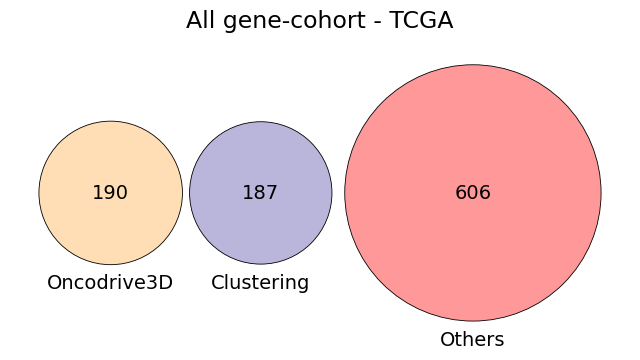

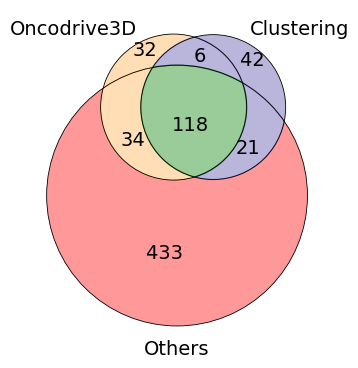

In [40]:
#====================
# All gene-cohort - TCGA
#====================

dict_hits, dict_cgc_hits, dict_fish_hits, dict_unknown_hits = get_hits_for_venn(genetable_subset, lst_methods, unique=False)

set1 = dict_hits["o3d"]
set2 = dict_hits["hotmaps"] | dict_hits["clustl"]
set3 = dict_hits["smreg"] | dict_hits["dndscv"] | dict_hits["mutpan"] | dict_hits["fml"] | dict_hits["cbase"]

labels = 'Oncodrive3D', 'Clustering', "Others"
colors = colors_dict["Oncodrive3D"], '#5247a6', 'red'

plot_venn3(set1, set2, set3,
           labels, colors, 
           title="All gene-cohort - TCGA",
           save=True,
           filename=f"{figures}/supplementary/s5/s5c_tcga_all_methods_gene_cohort.png")

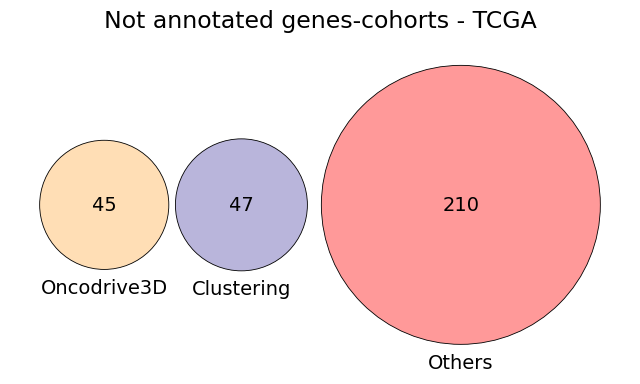

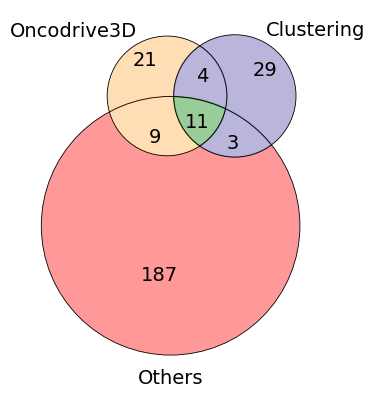

In [41]:
lst_methods = ["o3d", "hotmaps", "clustl", "smreg", "cbase", "dndscv", "mutpan", "fml"]

#====================
# Unkown genes - TCGA
#====================

dict_hits, dict_cgc_hits, dict_fish_hits, dict_unknown_hits = get_hits_for_venn(genetable_subset, lst_methods, unique=False)

set1 = dict_unknown_hits["o3d"]
set2 = dict_unknown_hits["hotmaps"] | dict_unknown_hits["clustl"]
set3 = dict_unknown_hits["smreg"] | dict_unknown_hits["dndscv"] | dict_unknown_hits["mutpan"] | dict_unknown_hits["fml"] | dict_unknown_hits["cbase"] #| dict_unknown_hits["seismic"]

labels = 'Oncodrive3D', 'Clustering', "Others"
colors = colors_dict["Oncodrive3D"], '#5247a6', 'red'

plot_venn3(set1, set2, set3,
           labels, colors, 
           title="Not annotated genes-cohorts - TCGA",
           save=False)

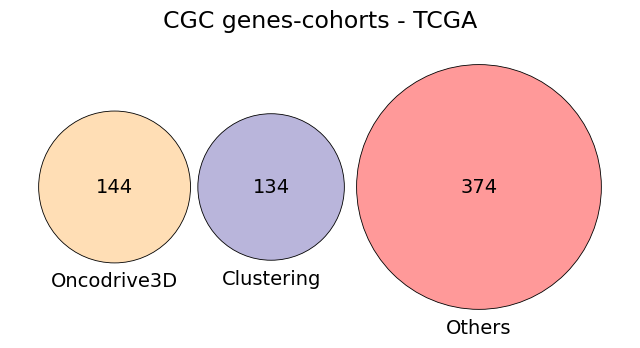

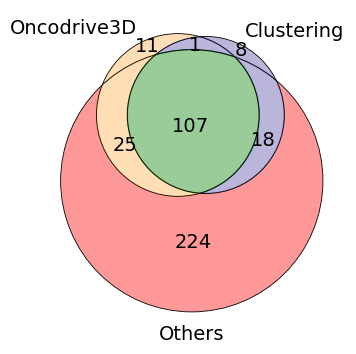

In [42]:
#==========
# CGC genes
#==========

set1 = dict_cgc_hits["o3d"]
set2 = dict_cgc_hits["hotmaps"] | dict_cgc_hits["clustl"]
set3 = dict_cgc_hits["smreg"] | dict_cgc_hits["dndscv"] | dict_cgc_hits["mutpan"] | dict_cgc_hits["fml"] | dict_cgc_hits["cbase"] 

plot_venn3(set1, set2, set3,
           labels, colors, 
           title="CGC genes-cohorts - TCGA",
           save=True,
           filename=f"{figures}/supplementary/s5/s5d_tcga_all_methods_gene_cohort_cgc.png")

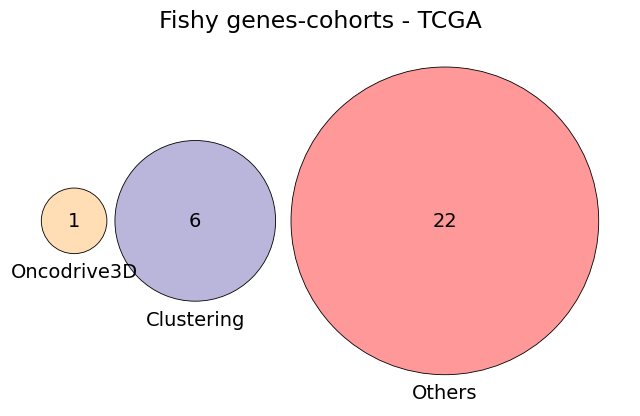

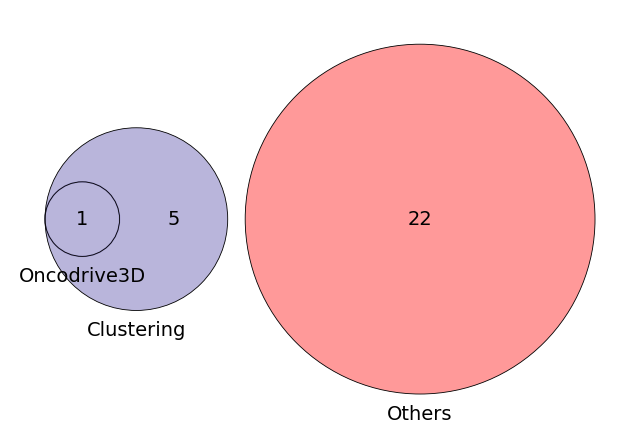

In [43]:
#==========
# Fish genes
#==========

set1 = dict_fish_hits["o3d"]
set2 = dict_fish_hits["hotmaps"] | dict_fish_hits["clustl"]
set3 = dict_fish_hits["smreg"] | dict_fish_hits["dndscv"] | dict_fish_hits["mutpan"] | dict_fish_hits["fml"] | dict_fish_hits["cbase"]

plot_venn3(set1, set2, set3,
           labels, colors, 
           figsize_venn=(8, 9),
           title="Fishy genes-cohorts - TCGA",
           save=False)

#### Unique genes

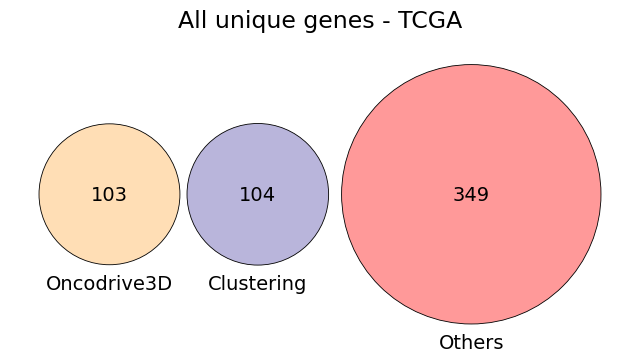

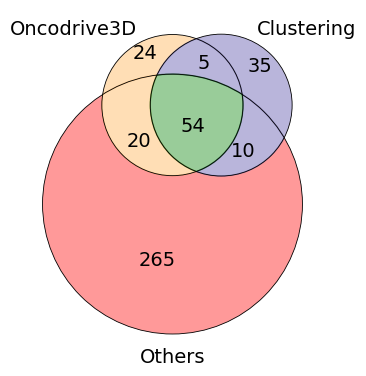

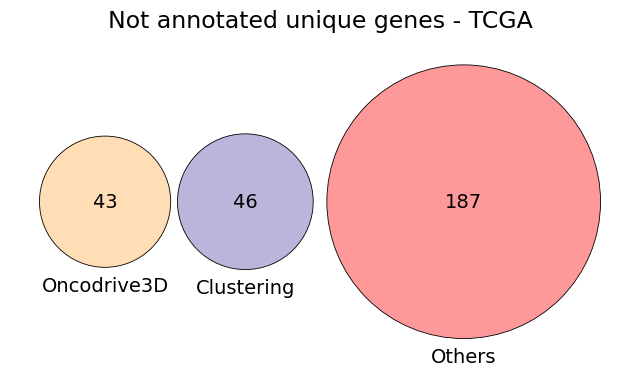

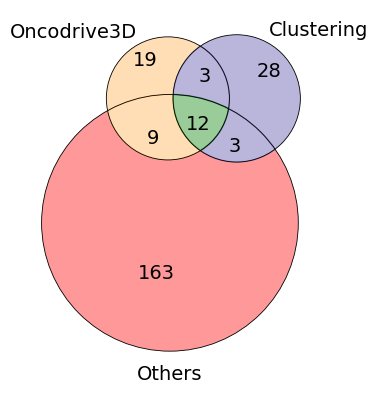

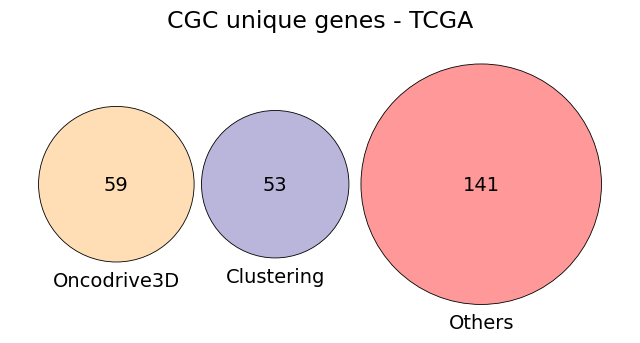

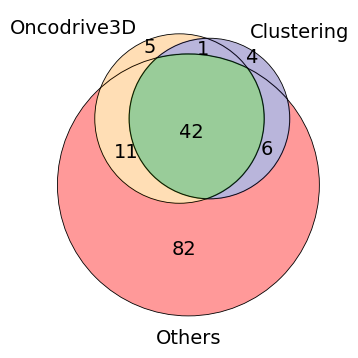

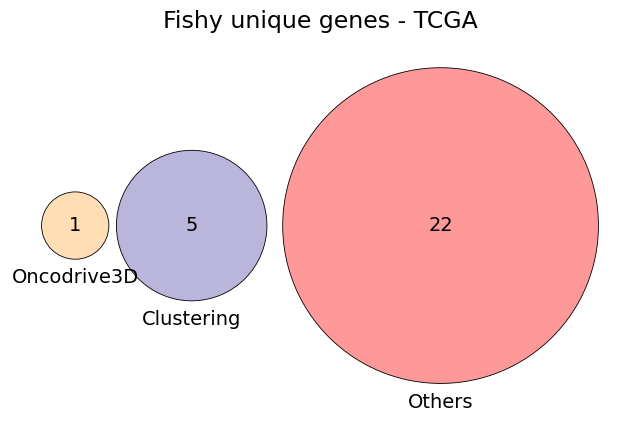

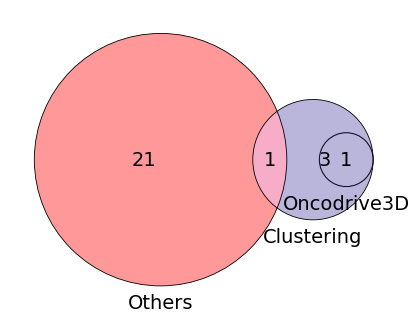

In [44]:
#================================
# All genes - TCGA - Unique genes
#================================

dict_hits, dict_cgc_hits, dict_fish_hits, dict_unknown_hits = get_hits_for_venn(genetable_subset, lst_methods, unique=True)

set1 = dict_hits["o3d"]
set2 = dict_hits["hotmaps"] | dict_hits["clustl"]
set3 = dict_hits["smreg"] | dict_hits["dndscv"] | dict_hits["mutpan"] | dict_hits["fml"] | dict_hits["cbase"]

labels = 'Oncodrive3D', 'Clustering', "Others"
colors = colors_dict["Oncodrive3D"], '#5247a6', 'red'

plot_venn3(set1, set2, set3,
           labels, colors, 
           title="All unique genes - TCGA",
           save=True,
           filename=f"{figures}/main/f4/f4c_tcga_all_methods_unique_genes.png")
print("\n\n")

#====================
# Unkown genes - TCGA
#====================

set1 = dict_unknown_hits["o3d"]
set2 = dict_unknown_hits["hotmaps"] | dict_unknown_hits["clustl"]
set3 = dict_unknown_hits["smreg"] | dict_unknown_hits["dndscv"] | dict_unknown_hits["mutpan"] | dict_unknown_hits["fml"] | dict_unknown_hits["cbase"] #| dict_unknown_hits["seismic"]

labels = 'Oncodrive3D', 'Clustering', "Others"
colors = colors_dict["Oncodrive3D"], '#5247a6', 'red'

plot_venn3(set1, set2, set3,
           labels, colors, 
           title="Not annotated unique genes - TCGA",
           save=False)
print("\n\n")

#==========
# CGC genes
#==========

set1 = dict_cgc_hits["o3d"]
set2 = dict_cgc_hits["hotmaps"] | dict_cgc_hits["clustl"]
set3 = dict_cgc_hits["smreg"] | dict_cgc_hits["dndscv"] | dict_cgc_hits["mutpan"] | dict_cgc_hits["fml"] | dict_cgc_hits["cbase"]

plot_venn3(set1, set2, set3,
           labels, colors, 
           title="CGC unique genes - TCGA",
           save=True,
           filename=f"{figures}/main/f4/f4d_tcga_all_methods_unique_genes_cgc.png")
print("\n\n")

#==========
# Fish genes
#==========

set1 = dict_fish_hits["o3d"]
set2 = dict_fish_hits["hotmaps"] | dict_fish_hits["clustl"]
set3 = dict_fish_hits["smreg"] | dict_fish_hits["dndscv"] | dict_fish_hits["mutpan"] | dict_fish_hits["fml"] | dict_fish_hits["cbase"]

plot_venn3(set1, set2, set3,
           labels, colors, 
           figsize_venn=(5, 6),
           title="Fishy unique genes - TCGA",
           save=False)

In [45]:
# CGC genes detected only by Oncodrive3D
set1 = dict_cgc_hits["o3d"]
set2 = dict_cgc_hits["hotmaps"] | dict_cgc_hits["clustl"]
set3 = dict_cgc_hits["smreg"] | dict_cgc_hits["dndscv"] | dict_cgc_hits["mutpan"] | dict_cgc_hits["fml"] | dict_cgc_hits["cbase"]
[gene for gene in set1 if gene not in list(set2) + list(set3)]

['KAT6A', 'MED12', 'BMP5', 'CDK4', 'KNSTRN']

In [46]:
# Not-CGC genes detected by all methods
set1 = dict_unknown_hits["o3d"]
set2 = dict_unknown_hits["hotmaps"] | dict_unknown_hits["clustl"]
set3 = dict_unknown_hits["smreg"] | dict_unknown_hits["dndscv"] | dict_unknown_hits["mutpan"] | dict_unknown_hits["fml"] | dict_unknown_hits["cbase"] 
[gene for gene in set1 if gene in list(set2) and gene in list(set3)]

['RXRA',
 'CNOT9',
 'SOX17',
 'TOP2A',
 'GTF2I',
 'GNA13',
 'CRIP3',
 'EEF1A1',
 'AGAP6',
 'RBM39',
 'PPP3CA',
 'SOS1']

### Clustering methods

#### Gene-cohort

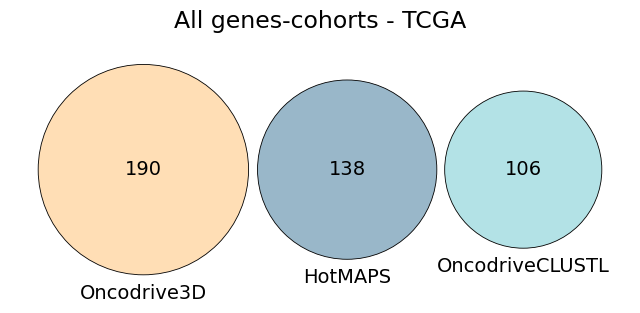

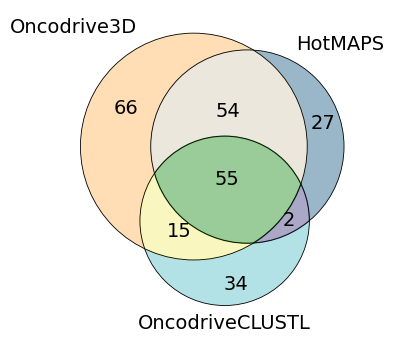

In [47]:
#=============================================================
# All genes - TCGA - Oncodrive3D VS HotMAPS VS OncodriveCLUSTL
#=============================================================

lst_methods = ["o3d", "hotmaps", "clustl", "smreg", "cbase", "dndscv", "mutpan", "fml"]
dict_hits, dict_cgc_hits, dict_fish_hits, dict_unknown_hits  = get_hits_for_venn(genetable_subset, lst_methods, unique=False)

set1 = dict_hits["o3d"]
set2 = dict_hits["hotmaps"]
set3 = dict_hits["clustl"]

labels = 'Oncodrive3D', 'HotMAPS', "OncodriveCLUSTL"
colors = colors_dict[names_dict["o3d"]], colors_dict[names_dict["hotmaps"]], colors_dict[names_dict["clustl"]]

plot_venn3(set1, set2, set3, labels, colors, title="All genes-cohorts - TCGA", clustering_groups=True,
           save=True,
           filename=f"{figures}/supplementary/s5/s5a_tcga_clustering_methods_gene_cohort.png")

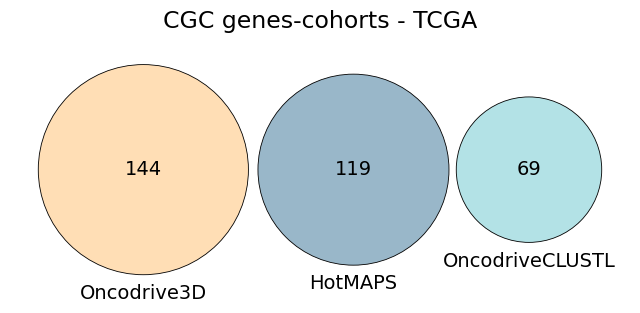

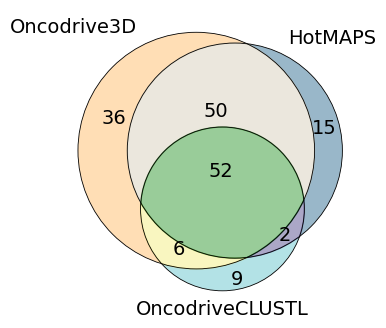

In [48]:
#==========
# CGC genes
#==========

set1 = dict_cgc_hits["o3d"]
set2 = dict_cgc_hits["hotmaps"]
set3 = dict_cgc_hits["clustl"]

plot_venn3(set1, set2, set3, labels, colors, title="CGC genes-cohorts - TCGA", clustering_groups=True,
           save=True,
           filename=f"{figures}/supplementary/s5/s5a_tcga_clustering_methods_gene_cohort_cgc.png")

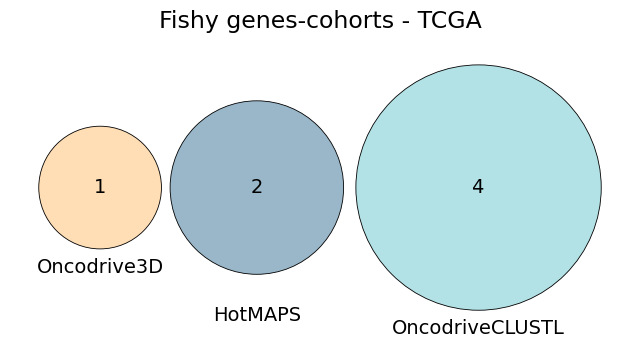

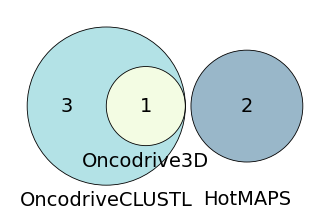

In [49]:
#==========
# Fish genes
#==========

set1 = dict_fish_hits["o3d"]
set2 = dict_fish_hits["hotmaps"]
set3 = dict_fish_hits["clustl"]

labels = 'Oncodrive3D', '\nHotMAPS', "OncodriveCLUSTL"
plot_venn3(set1, set2, set3, labels, colors, title="Fishy genes-cohorts - TCGA", clustering_groups=True,
           save=False)

#### Unique genes

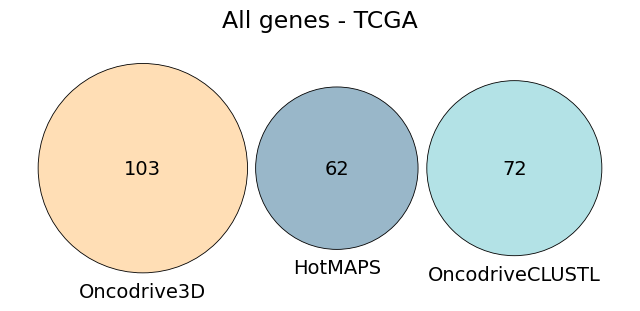

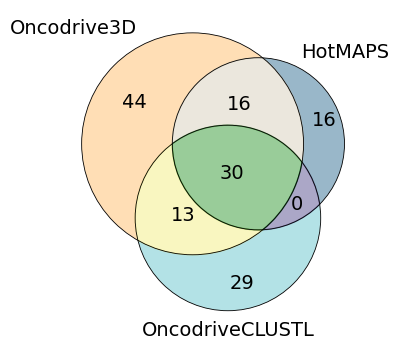

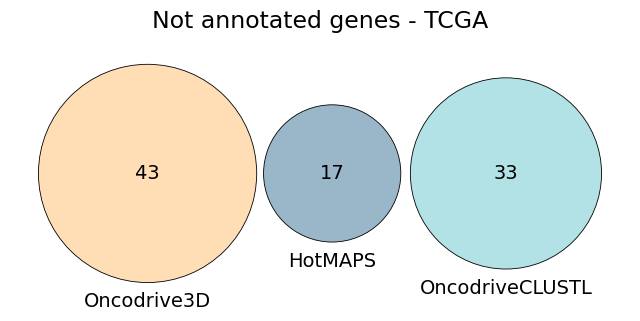

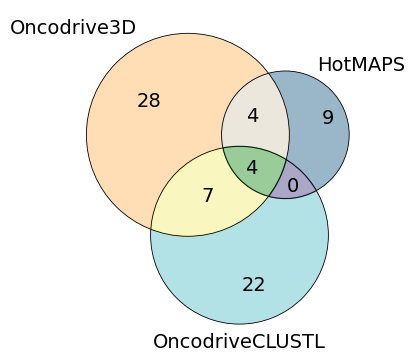

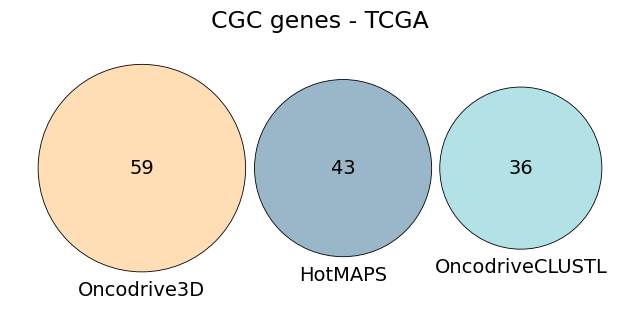

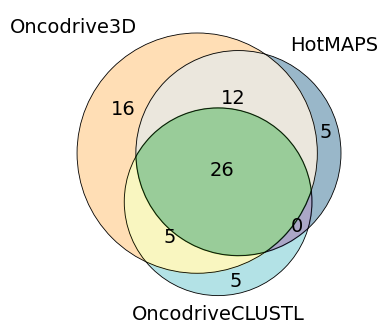

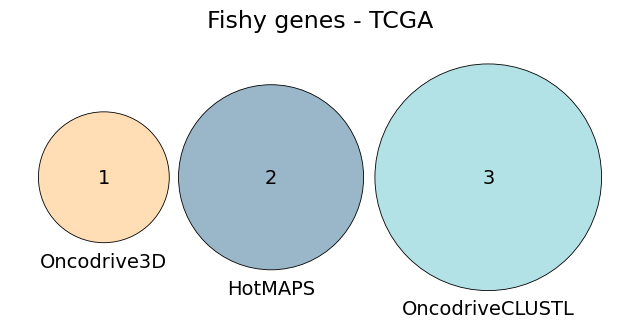

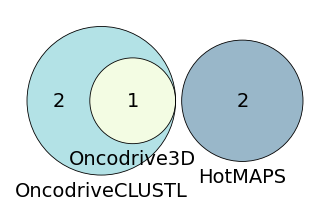

In [50]:
#X ================================================================
# Unique genes - TCGA - Oncodrive3D VS HotMAPS VS OncodriveCLUSTL
#X ================================================================

#==========
# All genes
#==========

dict_hits, dict_cgc_hits, dict_fish_hits, dict_unknown_hits  = get_hits_for_venn(genetable_subset, lst_methods, unique=True)

set1 = dict_hits["o3d"]
set2 = dict_hits["hotmaps"]
set3 = dict_hits["clustl"]

labels = 'Oncodrive3D', 'HotMAPS', "OncodriveCLUSTL"
colors = colors_dict[names_dict["o3d"]], colors_dict[names_dict["hotmaps"]], colors_dict[names_dict["clustl"]]

plot_venn3(set1, set2, set3, labels, colors, title="All genes - TCGA", clustering_groups=True,
           save=True,
           filename=f"{figures}/main/f4/f4a_tcga_clustering_methods_unique_genes.png")
print("\n\n")

#==========
# Not annotated genes
#==========

set1 = dict_unknown_hits["o3d"]
set2 = dict_unknown_hits["hotmaps"]
set3 = dict_unknown_hits["clustl"]

plot_venn3(set1, set2, set3, labels, colors, title="Not annotated genes - TCGA", clustering_groups=True,
           save=False)
print("\n\n")

#==========
# CGC genes
#==========

set1 = dict_cgc_hits["o3d"]
set2 = dict_cgc_hits["hotmaps"]
set3 = dict_cgc_hits["clustl"]

plot_venn3(set1, set2, set3, labels, colors, title="CGC genes - TCGA", clustering_groups=True,
           save=True,
           filename=f"{figures}/main/f4/f4b_tcga_clustering_methods_unique_genes_cgc.png")
print("\n\n")

#===========
# Fish genes
#===========

set1 = dict_fish_hits["o3d"]
set2 = dict_fish_hits["hotmaps"]
set3 = dict_fish_hits["clustl"]

plot_venn3(set1, set2, set3, labels, colors, title="Fishy genes - TCGA", clustering_groups=True,
           save=False)

## All cohorts

### All methods

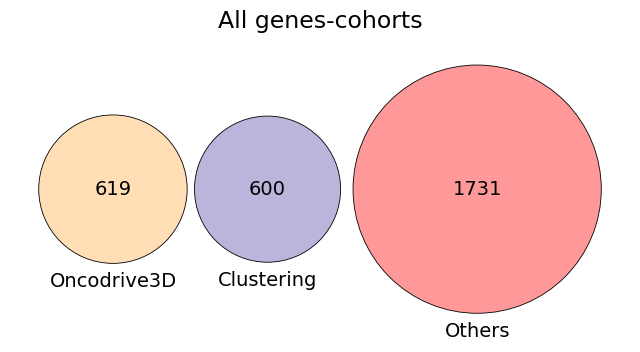

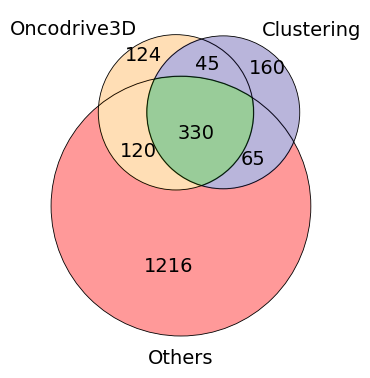

In [51]:
#==========
# All genes
#==========

dict_hits, dict_cgc_hits, dict_fish_hits, dict_unknown_hits = get_hits_for_venn(genetable, lst_methods, unique=False)

set1 = dict_hits["o3d"]
set2 = dict_hits["hotmaps"] | dict_hits["clustl"]
set3 = dict_hits["smreg"] | dict_hits["dndscv"] | dict_unknown_hits["mutpan"] | dict_unknown_hits["fml"] | dict_unknown_hits["cbase"] #| dict_unknown_hits["seismic"]

labels = 'Oncodrive3D', 'Clustering', "Others"
colors = colors_dict["Oncodrive3D"], '#5247a6', 'red'

plot_venn3(set1, set2, set3,
           labels, colors, 
           title="All genes-cohorts",
           save=True,
           filename=f"{figures}/supplementary/s6/s6g_all_cohorts_all_methods_gene_cohort.png")

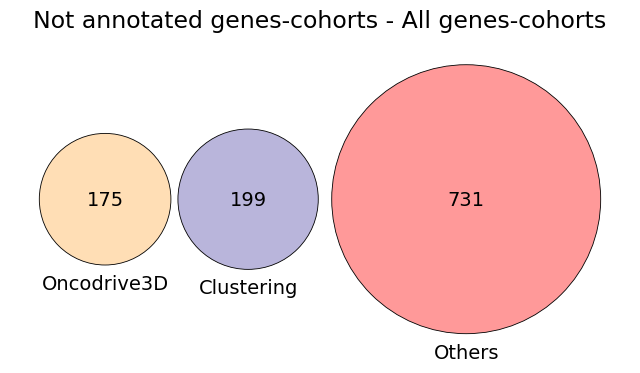

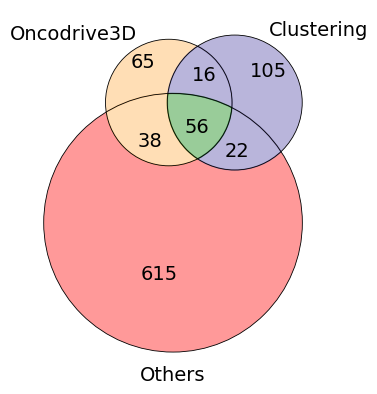

In [52]:
#==============
# Unkown genes 
#==============

set1 = dict_unknown_hits["o3d"]
set2 = dict_unknown_hits["hotmaps"] | dict_unknown_hits["clustl"]
set3 = dict_unknown_hits["smreg"] | dict_unknown_hits["dndscv"] | dict_unknown_hits["mutpan"] | dict_unknown_hits["fml"] | dict_unknown_hits["cbase"] #| dict_unknown_hits["seismic"]

labels = 'Oncodrive3D', 'Clustering', "Others"
colors = colors_dict["Oncodrive3D"], '#5247a6', 'red'

plot_venn3(set1, set2, set3,
           labels, colors, 
           title="Not annotated genes-cohorts - All genes-cohorts",
           save=False)

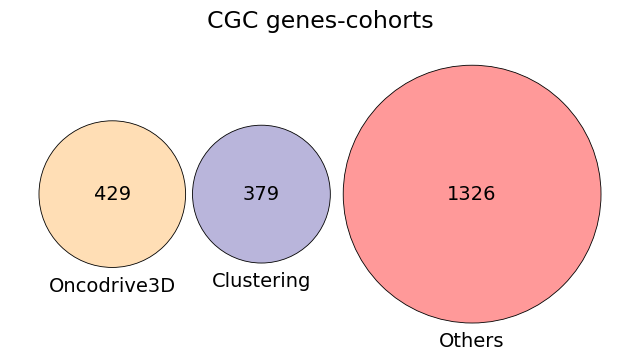

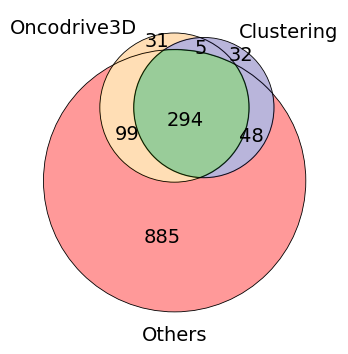

In [53]:
#==========
# CGC genes
#==========

set1 = dict_cgc_hits["o3d"]
set2 = dict_cgc_hits["hotmaps"] | dict_cgc_hits["clustl"]
set3 = dict_cgc_hits["smreg"] | dict_cgc_hits["dndscv"] | dict_cgc_hits["mutpan"] | dict_cgc_hits["fml"] | dict_cgc_hits["cbase"] #| dict_unknown_hits["seismic"]

plot_venn3(set1, set2, set3,
           labels, colors, 
           title="CGC genes-cohorts",
           save=True,
           filename=f"{figures}/supplementary/s6/s6h_all_cohorts_all_methods_gene_cohort_cgc.png")

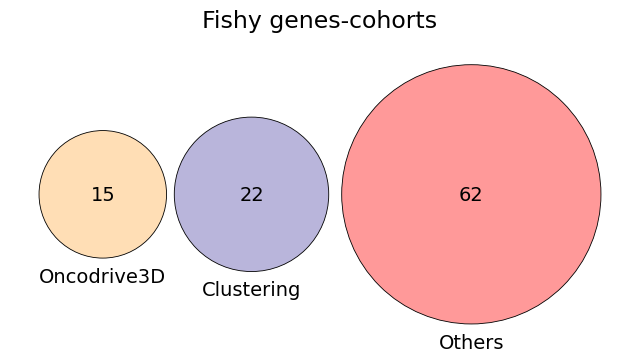

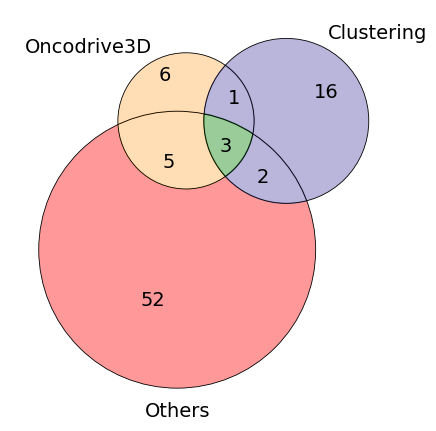

In [54]:
#==========
# Fish genes
#==========

set1 = dict_fish_hits["o3d"]
set2 = dict_fish_hits["hotmaps"] | dict_fish_hits["clustl"]
set3 = dict_fish_hits["smreg"] | dict_fish_hits["dndscv"] | dict_fish_hits["mutpan"] | dict_fish_hits["fml"] | dict_fish_hits["cbase"] #| dict_unknown_hits["seismic"]

plot_venn3(set1, set2, set3,
           labels, colors, 
           figsize_venn=(5, 7),
           title="Fishy genes-cohorts")

#### Unique genes

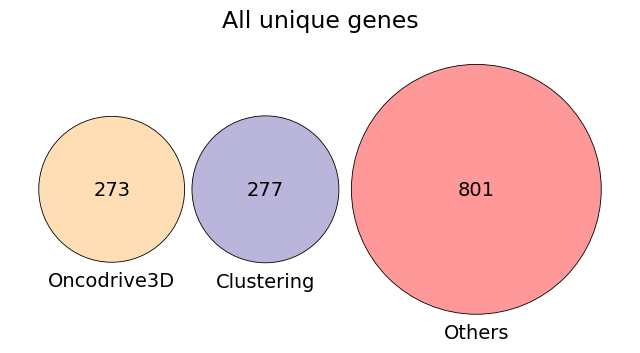

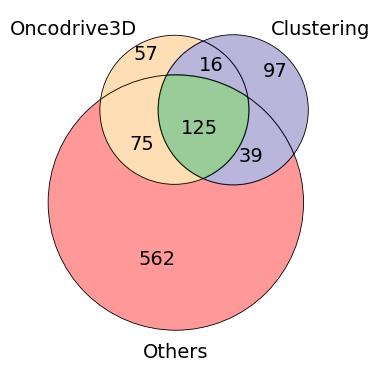

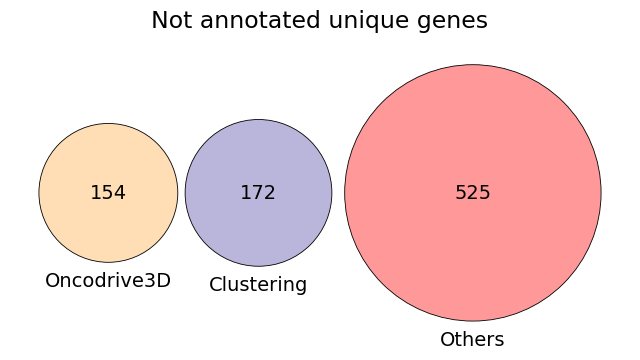

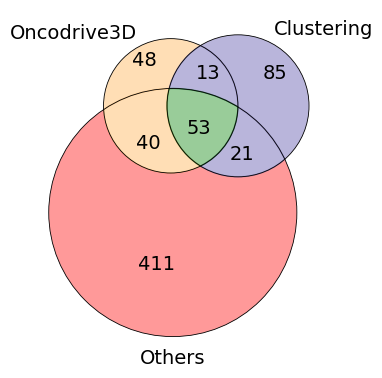

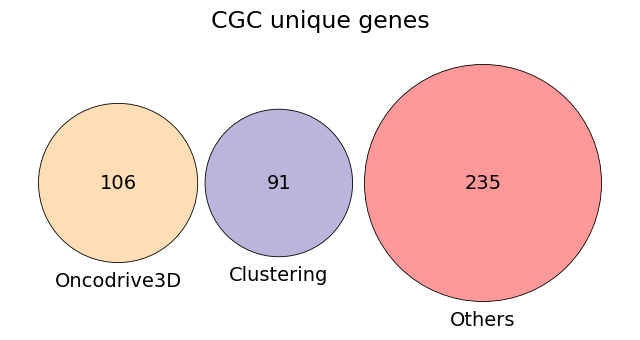

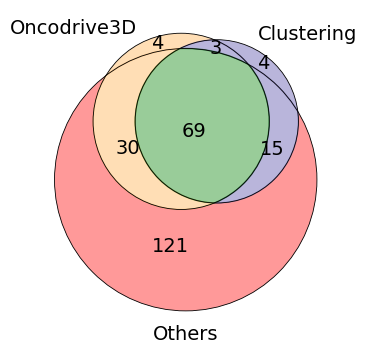

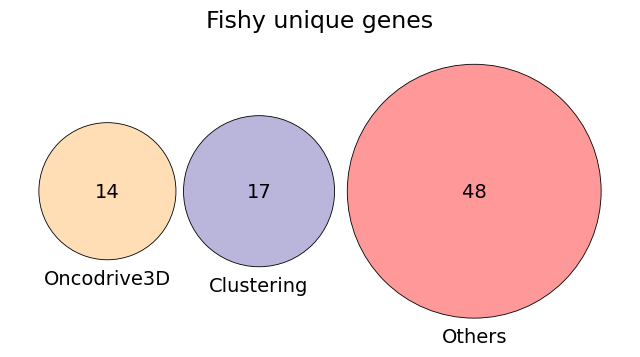

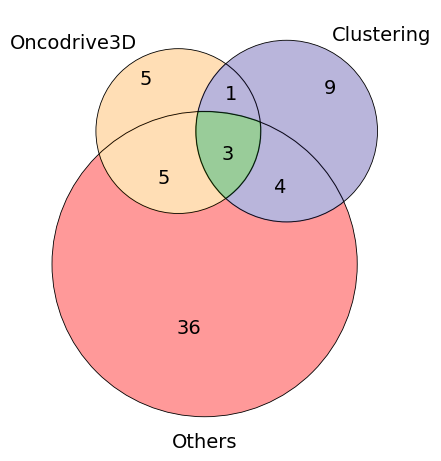

In [55]:
#=========================
# All genes - Unique genes
#=========================

dict_hits, dict_cgc_hits, dict_fish_hits, dict_unknown_hits = get_hits_for_venn(genetable, lst_methods, unique=True)

set1 = dict_hits["o3d"]
set2 = dict_hits["hotmaps"] | dict_hits["clustl"]
set3 = dict_hits["smreg"] | dict_hits["dndscv"] | dict_hits["mutpan"] | dict_hits["fml"] | dict_hits["cbase"]

labels = 'Oncodrive3D', 'Clustering', "Others"
colors = colors_dict["Oncodrive3D"], '#5247a6', 'red'

plot_venn3(set1, set2, set3,
           labels, colors, 
           title="All unique genes",
           save=True,
           filename=f"{figures}/supplementary/s6/s6c_all_cohorts_all_methods_unique_genes.png")

print("\n\n")

#==============
# Unkown genes 
#==============

set1 = dict_unknown_hits["o3d"]
set2 = dict_unknown_hits["hotmaps"] | dict_unknown_hits["clustl"]
set3 = dict_unknown_hits["smreg"] | dict_unknown_hits["dndscv"] | dict_unknown_hits["mutpan"] | dict_unknown_hits["fml"] | dict_unknown_hits["cbase"] 

labels = 'Oncodrive3D', 'Clustering', "Others"
colors = colors_dict["Oncodrive3D"], '#5247a6', 'red'

plot_venn3(set1, set2, set3,
           labels, colors, 
           title="Not annotated unique genes",
           save=True,
           filename=f"{figures}/supplementary/s11/s11a_all_cohorts_all_methods_unique_genes_unknown.png")
print("\n\n")

#==========
# CGC genes
#==========

set1 = dict_cgc_hits["o3d"]
set2 = dict_cgc_hits["hotmaps"] | dict_cgc_hits["clustl"]
set3 = dict_cgc_hits["smreg"] | dict_cgc_hits["dndscv"] | dict_cgc_hits["mutpan"] | dict_cgc_hits["fml"] | dict_cgc_hits["cbase"]

plot_venn3(set1, set2, set3,
           labels, colors, 
           title="CGC unique genes",
           save=True,
           filename=f"{figures}/supplementary/s6/s6d_all_cohorts_all_methods_unique_genes_cgc.png")
print("\n\n")

#==========
# Fish genes
#==========

set1 = dict_fish_hits["o3d"]
set2 = dict_fish_hits["hotmaps"] | dict_fish_hits["clustl"]
set3 = dict_fish_hits["smreg"] | dict_fish_hits["dndscv"] | dict_fish_hits["mutpan"] | dict_fish_hits["fml"] | dict_fish_hits["cbase"]

plot_venn3(set1, set2, set3,
           labels, colors, 
           figsize_venn=(5, 7),
           title="Fishy unique genes")

### Clustering methods

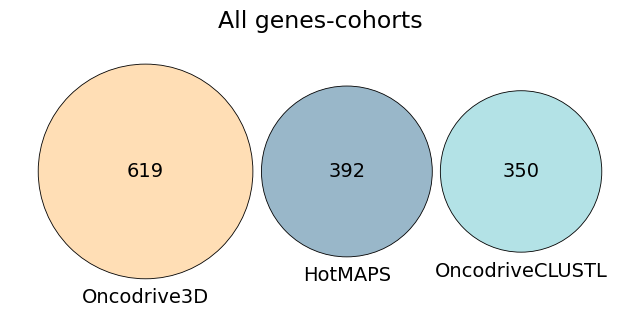

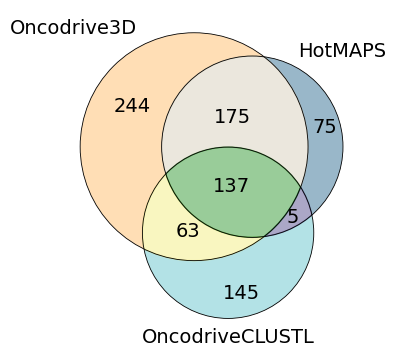

In [56]:
#======================================================
# All genes - Oncodrive3D VS HotMAPS VS OncodriveCLUSTL
#======================================================

dict_hits, dict_cgc_hits, dict_fish_hits, dict_unknown_hits = get_hits_for_venn(genetable, lst_methods, unique=False)

set1 = dict_hits["o3d"]
set2 = dict_hits["hotmaps"]
set3 = dict_hits["clustl"]

labels = 'Oncodrive3D', 'HotMAPS', "OncodriveCLUSTL"
colors = colors_dict[names_dict["o3d"]], colors_dict[names_dict["hotmaps"]], colors_dict[names_dict["clustl"]]

plot_venn3(set1, set2, set3, labels, colors, title="All genes-cohorts", clustering_groups=True,
           save=True,
           filename=f"{figures}/supplementary/s6/s6e_all_cohorts_clustering_methods_gene_cohort.png")

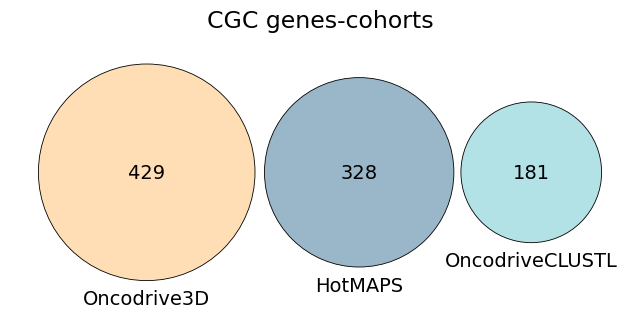

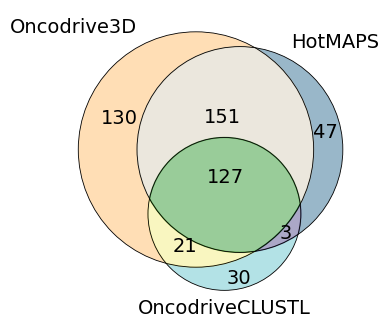

In [57]:
#==========
# CGC genes
#==========

set1 = dict_cgc_hits["o3d"]
set2 = dict_cgc_hits["hotmaps"]
set3 = dict_cgc_hits["clustl"]

plot_venn3(set1, set2, set3, labels, colors, title="CGC genes-cohorts", clustering_groups=True,
           save=True,
           filename=f"{figures}/supplementary/s6/s6f_all_cohorts_clustering_methods_gene_cohort_cgc.png")

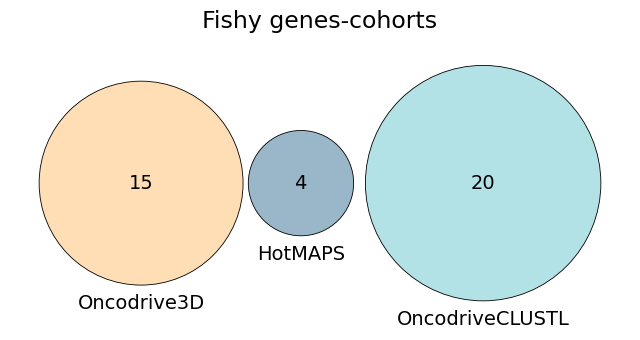

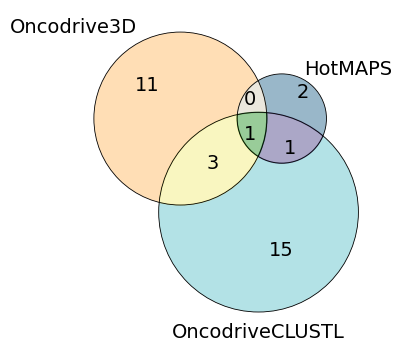

In [58]:
#==========
# Fish genes
#==========

set1 = dict_fish_hits["o3d"]
set2 = dict_fish_hits["hotmaps"]
set3 = dict_fish_hits["clustl"]

plot_venn3(set1, set2, set3, labels, colors, title="Fishy genes-cohorts", clustering_groups=True)

#### Unique genes

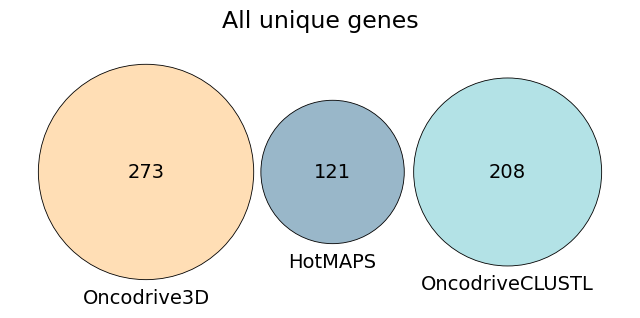

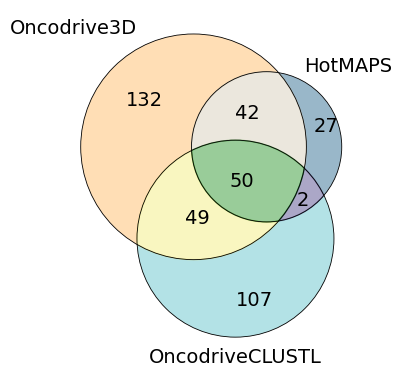

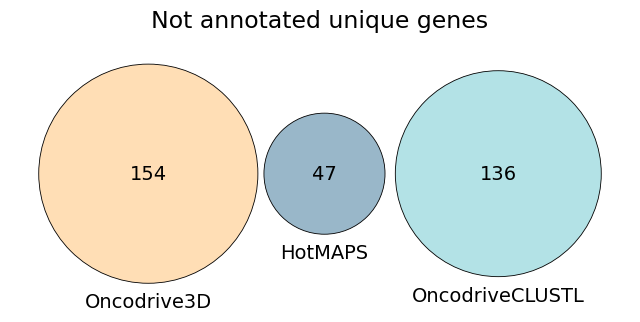

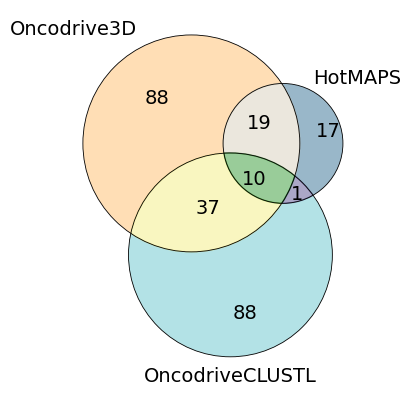

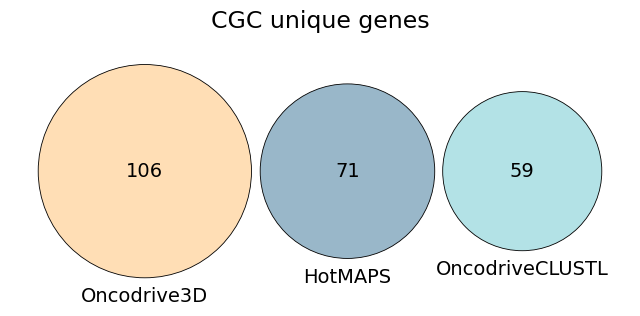

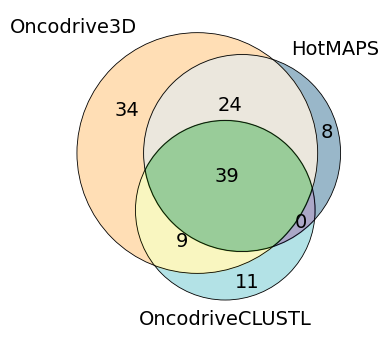

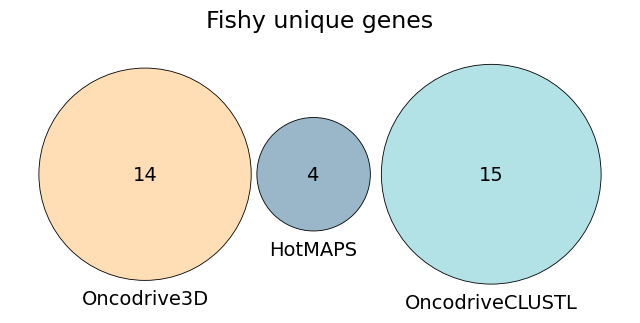

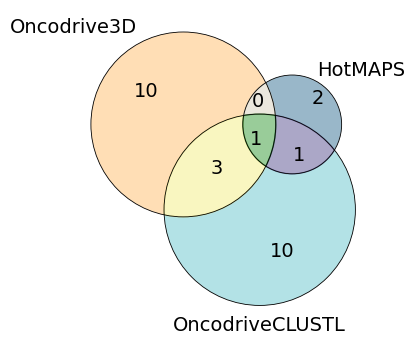

In [59]:
#=====================================================================
# All genes - Oncodrive3D VS HotMAPS VS OncodriveCLUSTL - Unique genes
#=====================================================================

dict_hits, dict_cgc_hits, dict_fish_hits, dict_unknown_hits = get_hits_for_venn(genetable, lst_methods, unique=True)

set1 = dict_hits["o3d"]
set2 = dict_hits["hotmaps"]
set3 = dict_hits["clustl"]

labels = 'Oncodrive3D', 'HotMAPS', "OncodriveCLUSTL"
colors = colors_dict[names_dict["o3d"]], colors_dict[names_dict["hotmaps"]], colors_dict[names_dict["clustl"]]

plot_venn3(set1, set2, set3, labels, colors, title="All unique genes", clustering_groups=True,
           save=True,
           filename=f"{figures}/supplementary/s6/s6a_all_cohorts_clustering_methods_unique_genes.png")
print("\n\n")

#==========
# Not annotated genes
#==========

set1 = dict_unknown_hits["o3d"]
set2 = dict_unknown_hits["hotmaps"]
set3 = dict_unknown_hits["clustl"]

plot_venn3(set1, set2, set3, labels, colors, title="Not annotated unique genes", clustering_groups=True)
print("\n\n")

#==========
# CGC genes
#==========

set1 = dict_cgc_hits["o3d"]
set2 = dict_cgc_hits["hotmaps"]
set3 = dict_cgc_hits["clustl"]

plot_venn3(set1, set2, set3, labels, colors, title="CGC unique genes", clustering_groups=True,
           save=True,
           filename=f"{figures}/supplementary/s6/s6b_all_cohorts_clustering_methods_unique_genes_cgc.png")
print("\n\n")

#==========
# Fish genes
#==========

set1 = dict_fish_hits["o3d"]
set2 = dict_fish_hits["hotmaps"]
set3 = dict_fish_hits["clustl"]

plot_venn3(set1, set2, set3, labels, colors, title="Fishy unique genes", clustering_groups=True)

## CH Venn

In [7]:
o3d_output_dir_ch = f"{datasets}/output/ch/o3d_output/{SUBDIR_CH}/{RUN_CH}"
genetable_ch = pd.read_table(f"/workspace/projects/clustering_3d/o3d_analysys/o3d_paper/notebooks/0.genetables/results/ch/{RUN_CH}.genetable.tsv")
ch_intogen_df = pd.read_csv(f"{datasets}/ch_genes.tsv", sep = '\t')
genetable_ch["CGC"] = genetable_ch["CH"]

FileNotFoundError: [Errno 2] No such file or directory: '/workspace/projects/clustering_3d/o3d_analysys/o3d_paper/notebooks/0.genetables/results/ch/run_2024-11-04_13-09-49.genetable.tsv'

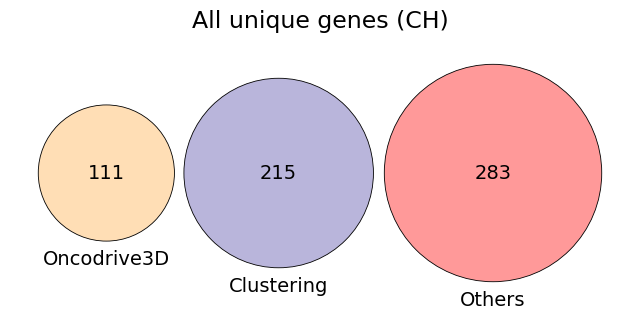

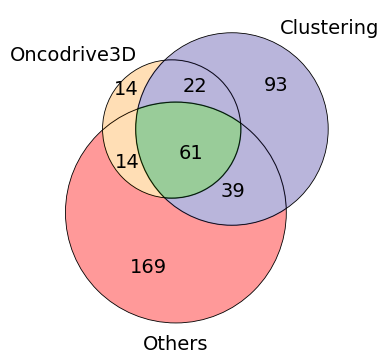

In [ ]:
#=========================
# All genes - Unique genes
#=========================

dict_hits, dict_cgc_hits, dict_fish_hits, dict_unknown_hits = get_hits_for_venn(genetable_ch, lst_methods, unique=True)

set1 = dict_hits["o3d"]
set2 = dict_hits["hotmaps"] | dict_hits["clustl"]
set3 = dict_hits["smreg"] | dict_hits["dndscv"] | dict_hits["mutpan"] | dict_hits["fml"] | dict_hits["cbase"]

labels = 'Oncodrive3D', 'Clustering', "Others"
colors = colors_dict["Oncodrive3D"], '#5247a6', 'red'

plot_venn3(set1, set2, set3,
           labels, colors, 
           title="All unique genes (CH)",
           save=True,
           filename=f"{figures}/supplementary/s12/s12b_all_methods_unique_genes_ch.png")

## Processed genes O3D & HotMAPS

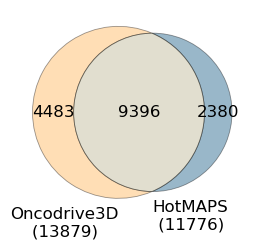

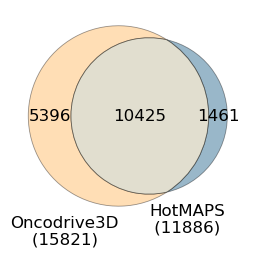

In [ ]:
groups = ["O3D", "HotMAPS", "OncodriveCLUSTL", "O3D-HotMAPS", "O3D-OncodriveCLUSTL", "HotMAPS-OncodriveCLUSTL", "All"]
colors = {"O3D" : colors_dict["Oncodrive3D"],
          "HotMAPS" : colors_dict["HotMAPS"], 
          "OncodriveCLUSTL" : colors_dict["OncodriveCLUSTL"], 
          "O3D-HotMAPS" : "#cec5ab", 
          "O3D-OncodriveCLUSTL" : "#f2e963", 
          "HotMAPS-OncodriveCLUSTL" : "#5247a6", 
          "All" : "green"}

# TCGA
# ====

set_o3d = set(genetable_subset[genetable_subset["o3d_status"] == "Processed"].Gene.unique())
set_hotmaps = set(genetable_subset.dropna(subset="hotmaps_qval").Gene.unique())

plt.figure(figsize=(3, 3)) 
venn = venn2([set_o3d, set_hotmaps],
             set_labels=[f'Oncodrive3D\n({len(set_o3d)})    ',f'HotMAPS\n ({len(set_hotmaps)})'],
             set_colors=[colors["O3D"], colors["HotMAPS"]])

# Add edges to the circles
for patch in venn.patches:
    if patch is not None:
        patch.set_edgecolor('black')  # Set the edge color
        patch.set_linewidth(0.6)  

# Increase the font size of the numbers
for label in venn.set_labels:
    if label is not None:
        label.set_fontsize(12)

for label in venn.subset_labels:
    if label is not None:
        label.set_fontsize(12)
        
plt.show()


# All cohorts
# ===========

set_o3d = set(genetable[genetable["o3d_status"] == "Processed"].Gene.unique())
set_hotmaps = set(genetable.dropna(subset="hotmaps_qval").Gene.unique())

plt.figure(figsize=(3, 3)) 
venn = venn2([set_o3d, set_hotmaps],
             set_labels=[f'Oncodrive3D\n({len(set_o3d)})    ',f'HotMAPS\n ({len(set_hotmaps)})'],
             set_colors=[colors["O3D"], colors["HotMAPS"]])

# Add edges to the circles
for patch in venn.patches:
    if patch is not None:
        patch.set_edgecolor('black')  # Set the edge color
        patch.set_linewidth(0.6)  

# Increase the font size of the numbers
for label in venn.set_labels:
    if label is not None:
        label.set_fontsize(12)

for label in venn.subset_labels:
    if label is not None:
        label.set_fontsize(12)
        
plt.show()

# 2) F4, S6, S11: Complementarity bar plots

## Functions

In [ ]:
def get_hits_set_cohort(dict_hits, cohort, groups, clustering_groups=False):

    g1 = dict_hits["o3d"]
    if clustering_groups:
        # Define groups
        g2 = dict_hits["hotmaps"]
        g3 = dict_hits["clustl"]
        
        # Get intersecions, etc
        intsec_all = g1 & g2 & g3
        g1_only = g1 - g2 - g3
        g2_only = g2 - g1 - g3
        g3_only = g3 - g2 - g1
        intsec_g1_g2 = (g1 & g2) - g3
        intsec_g1_g3 = (g1 & g3) - g2
        intsec_g2_g3 = (g2 & g3) - g1
    
        groups_values = [g1_only, g2_only, g3_only, intsec_g1_g2, intsec_g1_g3, intsec_g2_g3, intsec_all]

    else:
        # Define groups
        g2 = dict_hits["hotmaps"] | dict_hits["clustl"]
        #g3 = dict_hits["smreg"] | dict_hits["dndscv"] | dict_hits["mutpan"] | dict_hits["fml"]
        g3 = dict_hits["smreg"] | dict_hits["dndscv"] | dict_hits["mutpan"] | dict_hits["fml"] | dict_hits["cbase"] #| dict_hits["seismic"]
        
        # Get intersecions, etc
        intsec_all = g1 & g2 & g3
        g2_final = g2 - intsec_all
        g1_final = g1 - g2 - intsec_all
        g3_final = g3 - g1 - g2 - intsec_all
        
        groups_values = [intsec_all, g2_final, g1_final, g3_final]
        
    # Prepare df
    hits_set_cohort = [len(group) for group in groups_values]
    hits_set_cohort_df = pd.DataFrame({"Hits" : hits_set_cohort, "Group" : groups})
    hits_set_cohort_df["Cohort"] = cohort

    return hits_set_cohort_df


def get_hits_set(genetable_df, groups, lst_methods, clustering_groups=False):

    lst_df = []
    lst_unknown_df = []
    lst_cgc_df = []
    lst_fish_df = []
    
    for cohort in tqdm(genetable_df["Cohort"].unique()):
        method_cohort = genetable_df[genetable_df["Cohort"] == cohort].copy()

        dict_hits = {}
        dict_unknown_hits = {}
        dict_cgc_hits = {}
        dict_fish_hits = {}

        for method in lst_methods:
            method_hits_cohort = method_cohort[(method_cohort[f"{method}_qval"] < 0.01)]
            dict_hits[method] = set(list(method_hits_cohort.apply(
                lambda x: get_gene_cohort(x, gene_only=True), axis=1).values))
            dict_unknown_hits[method] = set(list(method_hits_cohort[(method_hits_cohort["CGC"] == 0) & 
                                                            (method_hits_cohort["Fish"] == 0)].apply(
                lambda x: get_gene_cohort(x, gene_only=True), axis=1).values))
            dict_cgc_hits[method] = set(list(method_hits_cohort[method_hits_cohort["CGC"] == 1].apply(
                lambda x: get_gene_cohort(x, gene_only=True), axis=1).values))
            dict_fish_hits[method] = set(list(method_hits_cohort[method_hits_cohort["Fish"] == 1].apply(
                lambda x: get_gene_cohort(x, gene_only=True), axis=1).values))

        lst_df.append(get_hits_set_cohort(dict_hits, cohort, groups, clustering_groups))
        lst_unknown_df.append(get_hits_set_cohort(dict_unknown_hits, cohort, groups, clustering_groups))
        lst_cgc_df.append(get_hits_set_cohort(dict_cgc_hits, cohort, groups, clustering_groups))
        lst_fish_df.append(get_hits_set_cohort(dict_fish_hits, cohort, groups, clustering_groups))

    hits_set_df = pd.concat(lst_df).reset_index(drop=True)
    hits_unknown_set_df = pd.concat(lst_unknown_df).reset_index(drop=True)
    hits_cgc_set_df = pd.concat(lst_cgc_df).reset_index(drop=True)
    hits_fish_set_df = pd.concat(lst_fish_df).reset_index(drop=True)
    
    return hits_set_df, hits_unknown_set_df, hits_cgc_set_df, hits_fish_set_df

In [ ]:
def get_cohort_gene_mut(maf, missense_only=False):
    
    if missense_only:
        maf = maf[maf["Variant_Classification"] == "Missense_Mutation"]
    
    cohort_gene_mut = maf.groupby("Hugo_Symbol").apply(
        lambda x: len(x)).reset_index().rename(columns={"Hugo_Symbol" : "Gene", 0 : "Count"})
    cohort_gene_mut = cohort_gene_mut.sort_values("Count", ascending=False).reset_index(drop=True)
    
    return cohort_gene_mut


def get_union_intsec_cohort(genetable_cohort_df, lst_methods):

    # Drop any genes with all NaN or 1
    qval_cols = [f"{method}_qval" for method in lst_methods]
    df = genetable_cohort_df.copy().reset_index(drop=True)
    ix = df.replace(1, np.nan).dropna(subset=qval_cols, how='all').index.values
    df = df.iloc[ix,:]
    
    ix_hits = df[qval_cols] < 0.01
    ix_hits_union = ix_hits.any(1)
    ix_hits_intsec = ix_hits.all(1)
    n_union = sum(ix_hits_union)
    n_intsec = sum(ix_hits_intsec) 
    
    return n_union, n_intsec


def get_union_intsec_hits(gentable_df, maf_dir, lst_methods, mut_thr=1):
    df = gentable_df.copy()
    lst_df = []
    
    # Read MAF files outside the loop
    maf_data = {}
    for cohort in tqdm(df["Cohort"].unique()):
        maf = pd.read_csv(f"{maf_dir}/{cohort}.in.maf", sep="\t", low_memory=False)
        maf_data[cohort] = maf
    
    for cohort in tqdm(df["Cohort"].unique()):
        cohort_df = df[df["Cohort"] == cohort].copy()
        
        # Filter genes with more than 'mut_thr' mutations
        gene_mut = get_cohort_gene_mut(maf_data[cohort], missense_only=False)
        genes_to_keep = gene_mut[gene_mut["Count"] >= mut_thr].Gene.values
        cohort_df = cohort_df[cohort_df["Gene"].isin(genes_to_keep)]
        
        df_cgc = cohort_df[cohort_df["CGC"] == 1]
        cgc_all = len(df_cgc)
        cgc_union, cgc_intsec = get_union_intsec_cohort(df_cgc, lst_methods)
        cgc_union_ratio, cgc_intsec_ratio = get_union_intsec_cohort(df_cgc, lst_methods)

        df_fish = cohort_df[cohort_df["Fish"] == 1]
        fish_all = len(df_fish)
        fish_union, fish_intsec = get_union_intsec_cohort(df_fish, lst_methods)
        fish_union_ratio, fish_intsec_ratio = get_union_intsec_cohort(df_fish, lst_methods)

        lst_df.append((cohort, 
                       cgc_all, cgc_union, cgc_intsec, 
                       cgc_union_ratio, cgc_intsec_ratio, 
                       fish_all, fish_union, fish_intsec, 
                       fish_union_ratio, fish_intsec_ratio))

    return pd.DataFrame(lst_df, columns=["Cohort",
                                         "cgc_all", "cgc_union", "cgc_intsec", 
                                         "cgc_union_r", "cgc_intsec_r", 
                                         "fish_all", "fish_union", "fish_intsec", 
                                         "fish_union_r", "fish_intsec_r"]).reset_index(drop=True)

In [ ]:
def barplot_hits_set(hits_set_df, 
                     intsec_union_df_o3d,
                     intsec_union_df_hotmaps,
                     color_dict, 
                     title="Detected genes across cohorts", 
                     figsize=(12, 8), 
                     plot_xticks=True, 
                     ec="black", 
                     xfsize=13, 
                     y_ax1_fsize=13,
                     y_ax2_fsize=13,
                     top_cohorts=None,
                     
                     legend_ax1=True,
                     legend_ax2=True,
                     
                     legend_ax1_fsize=10,
                     legend_ax2_fsize=12,
                     legend_ax1_ncol=1,
                     legend_ax2_ncol=1,
  
                     extract_cancer=False,
                     target="cgc",
                     
                     h_ratio=[1, 3],
                    
                     genes_thr=1):
    
    colors_palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
    hits_set_df=hits_set_df.copy()
    intsec_union_df_o3d=intsec_union_df_o3d.copy()
    intsec_union_df_hotmaps=intsec_union_df_hotmaps.copy()

    if extract_cancer:
        hits_set_df["Cohort"] = hits_set_df["Cohort"].apply(lambda x: x.split("_")[len(x.split("_"))-1])
        intsec_union_df_o3d["Cohort"] = intsec_union_df_o3d["Cohort"].apply(lambda x: x.split("_")[len(x.split("_"))-1])
        intsec_union_df_hotmaps["Cohort"] = intsec_union_df_hotmaps["Cohort"].apply(lambda x: x.split("_")[len(x.split("_"))-1])

    # Pivot the DataFrame to get 'Group' as columns and 'Cohort' as the index
    pivot_df = hits_set_df.pivot_table(index='Cohort', columns='Group', values='Hits', aggfunc='sum', fill_value=0)

    # Sort cohorts by detected genes
    cohort_totals = pivot_df.sum(axis=1).sort_values(ascending=False)
    cohort_totals = cohort_totals[cohort_totals >= genes_thr]
    pivot_df_sorted = pivot_df.loc[cohort_totals.index]
    intsec_union_df_o3d = intsec_union_df_o3d.set_index("Cohort")
    intsec_union_df_o3d = intsec_union_df_o3d.loc[cohort_totals.sort_values(ascending=False).index].fillna(0)
    intsec_union_df_hotmaps = intsec_union_df_hotmaps.set_index("Cohort")
    intsec_union_df_hotmaps = intsec_union_df_hotmaps.loc[cohort_totals.sort_values(ascending=False).index].fillna(0)
    if top_cohorts:
        pivot_df_sorted = pivot_df_sorted[:top_cohorts]
        intsec_union_df_o3d = intsec_union_df_o3d[:top_cohorts]
        intsec_union_df_hotmaps = intsec_union_df_hotmaps[:top_cohorts]

    ## Subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True, gridspec_kw={'height_ratios': h_ratio})

    # Barplot stacked by groups bottom
    pivot_df_sorted.plot(
        kind='bar', stacked=True, figsize=figsize, color=[color_dict[group] for group in pivot_df.columns], alpha=0.5, edgecolor=ec, ax=ax2)
    # Filled marked line plot above
    ax1.plot(intsec_union_df_hotmaps.index, intsec_union_df_hotmaps[f'{target}_union'], "-o", 
             color=colors_dic[names_dic["hotmaps"]], label='Methods ∪ with HotMAPS', lw=0.8, markersize=4, alpha=0.9)
    ax1.plot(intsec_union_df_hotmaps.index, intsec_union_df_hotmaps[f'{target}_intsec'], "--o", 
             color=colors_dic[names_dic["hotmaps"]], label='Methods ∩ with HotMAPS', lw=0.8, markersize=4, alpha=0.9)
    ax1.fill_between(intsec_union_df_hotmaps.index, intsec_union_df_o3d[f'{target}_intsec'], 
                     intsec_union_df_hotmaps[f'{target}_union'], color=colors_dic[names_dic["hotmaps"]], alpha=0.2)

    ax1.plot(intsec_union_df_o3d.index, intsec_union_df_o3d[f'{target}_union'], "-o", 
             color=colors_dic[names_dic["o3d"]], label='Methods ∪ with O3D', lw=0.8, markersize=4, alpha=0.9)
    ax1.plot(intsec_union_df_o3d.index, intsec_union_df_o3d[f'{target}_intsec'], "--o", 
             color=colors_dic[names_dic["o3d"]], label='Methods ∩ with O3D', lw=0.8, markersize=4, alpha=0.9)
    ax1.fill_between(intsec_union_df_o3d.index, intsec_union_df_o3d[f'{target}_intsec'], 
                     intsec_union_df_o3d[f'{target}_union'], color=colors_dic[names_dic["o3d"]], alpha=0.2)

    # Details
    if plot_xticks:    
        plt.xticks(rotation=45, rotation_mode="anchor", ha='right') 
    else:
        plt.xticks([])

    if legend_ax1:
        
        legend_elements = [
            mlines.Line2D([], [], color='black', linestyle='-', label='Methods ∪'),
            mlines.Line2D([], [], color='black', linestyle='--', label='Methods ∩'),
            mlines.Line2D([], [], color=colors_dic[names_dic["o3d"]], marker='o', label=f"With {names_dic['o3d']}"),
            mlines.Line2D([], [], color=colors_dic[names_dic["hotmaps"]], marker='o', label=f"With {names_dic['hotmaps']}")
        ]
        
        # Add the legend with the custom elements
        ax1.legend(handles=legend_elements)

    else:
        ax1.legend('', frameon=False)
    if legend_ax2:
        ax2.legend(ncol=legend_ax2_ncol, fontsize=legend_ax2_fsize)
    else:
        ax2.legend('', frameon=False)

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    plt.xlabel('Cohort', fontsize=xfsize)
    ax2.set_ylabel('Count', fontsize=y_ax1_fsize)
    ax1.set_ylabel('Count', fontsize=y_ax2_fsize)
    plt.subplots_adjust(hspace=0.05) 
    plt.suptitle(title, fontsize=16)
    plt.show()
    

def barplot_hits_set_simple(hits_set_df, 
                            color_dict, 
                            title, 
                            figsize=(12, 7), 
                            plot_xticks=True, 
                            ec="black", 
                            xlab_fontsize=16, 
                            ylab_fontsize=16, 
                            xtick_fontsize=12, 
                            ytick_fontsize=15, 
                            top_cohorts=None, 
                            extract_cancer=False, 
                            legend_ncol=1, 
                            legend_fontsize=14, 
                            legend=True,
                            save=False,
                            ylabel="Genes count",
                            xlabel="Cohort",
                            filename="barplot_complementarity.png"):

    hits_set_df = hits_set_df.copy()
    if extract_cancer:
        hits_set_df["Cohort"] = hits_set_df["Cohort"].apply(lambda x: x.split("_")[len(x.split("_"))-1])
        
    # Pivot the DataFrame to get 'Group' as columns and 'Cohort' as the index
    pivot_df = hits_set_df.pivot_table(index='Cohort', columns='Group', values='Hits', aggfunc='sum', fill_value=0)

    # Sort cohorts by detected genes
    cohort_totals = pivot_df.sum(axis=1)
    pivot_df_sorted = pivot_df.loc[cohort_totals.sort_values(ascending=False).index]
    if top_cohorts:
        pivot_df_sorted = pivot_df_sorted[:top_cohorts]

    # Sort cols in desired order
    groups_a = ["All", "O3D", "O3D-OncodriveCLUSTL", "O3D-HotMAPS", "HotMAPS", "HotMAPS-OncodriveCLUSTL", "OncodriveCLUSTL"]
    groups_b = ["All", "Oncodrive3D", "Clustering", "Others"]
    for groups in [groups_a, groups_b]:
        if all(item in groups for item in pivot_df_sorted.columns):
            pivot_df_sorted = pivot_df_sorted[groups]
        
    # Plot
    ax = pivot_df_sorted.plot(kind='bar', stacked=True, figsize=figsize, color=[color_dict[group] for group in pivot_df_sorted.columns], alpha=0.5, edgecolor=ec, lw=0.5)
    plt.xlabel(xlabel, fontsize=xlab_fontsize)
    plt.ylabel(ylabel, fontsize=ylab_fontsize)
    plt.title(title, fontsize=16)
    plt.yticks(fontsize=ytick_fontsize)
    if plot_xticks:    
        plt.xticks(rotation=45, rotation_mode="anchor", ha='right', fontsize=xtick_fontsize) 
    else:
        plt.xticks([])
    if legend:
        plt.legend(fontsize=legend_fontsize, ncol=legend_ncol, frameon=False)
    else:
        plt.legend('', frameon=False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    if save:
        plt.savefig(filename, dpi=900, bbox_inches='tight')
    plt.show()

## TCGA (main)

### All methods

100%|██████████| 32/32 [00:01<00:00, 24.03it/s]


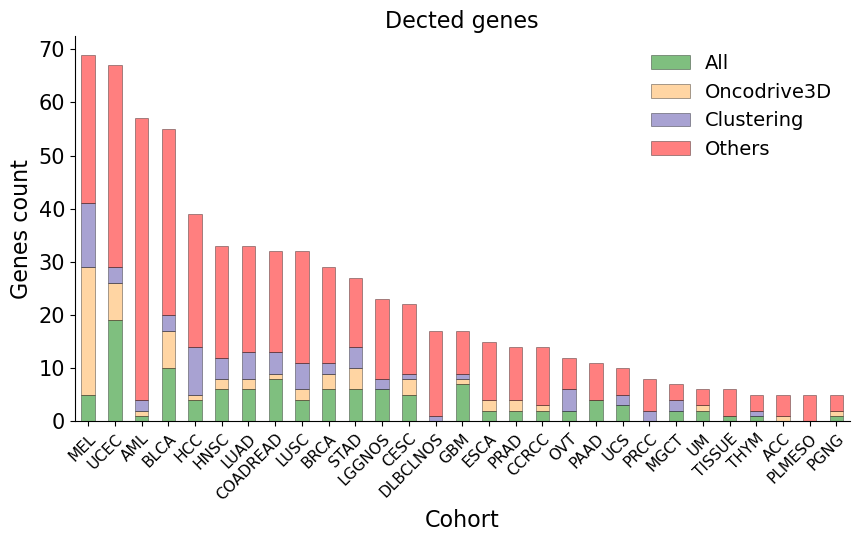

In [67]:
lst_methods = ["o3d", "hotmaps", "clustl", "smreg", "cbase", "dndscv", "mutpan", "fml"]
groups = ["All", "Clustering", "Oncodrive3D", "Others"]
colors = {"Oncodrive3D" : colors_dict[names_dict["o3d"]],
          "Clustering" : "#5247a6", 
          "Others" : "red", 
          "All" : "green"}

hits_set_df, hits_unknown_set_df, hits_cgc_set_df, hits_fish_set_df = get_hits_set(genetable_subset, groups, lst_methods, clustering_groups=False)

barplot_hits_set_simple(hits_set_df, 
                        figsize=(10, 5),
                        color_dict=colors, title='Dected genes', 
                        extract_cancer=True, 
                        xtick_fontsize=11,
                        top_cohorts=29, 
                        save=True, 
                        ylabel="Genes count",
                        filename=f"{figures}/main/f4/f4c.barplot_tcga_all_methods.png")

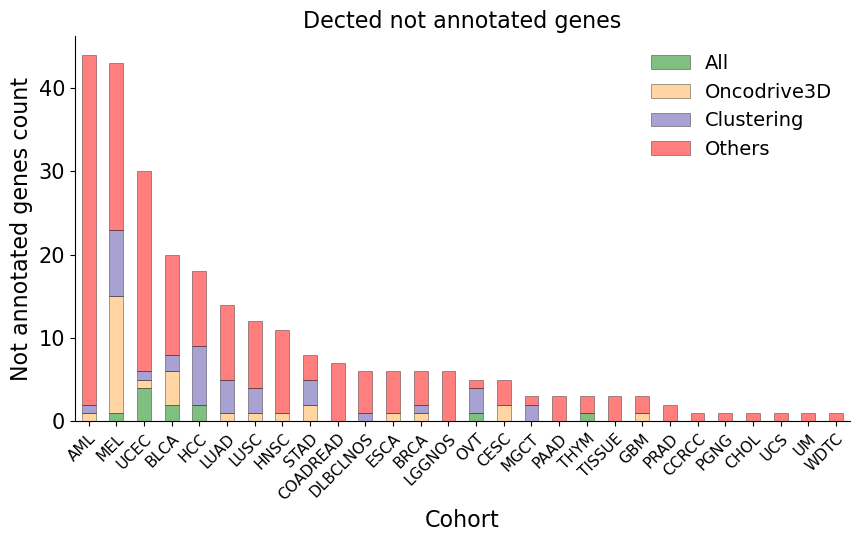

In [68]:
hits_unknown_set_df = hits_unknown_set_df.groupby("Cohort").filter(lambda x: x["Hits"].sum() > 0).reset_index(drop=True)
barplot_hits_set_simple(hits_unknown_set_df, 
                        figsize=(10, 5),
                        color_dict=colors, title='Dected not annotated genes', 
                        extract_cancer=True, 
                        xtick_fontsize=11,
                        top_cohorts=29, 
                        ylabel="Not annotated genes count")

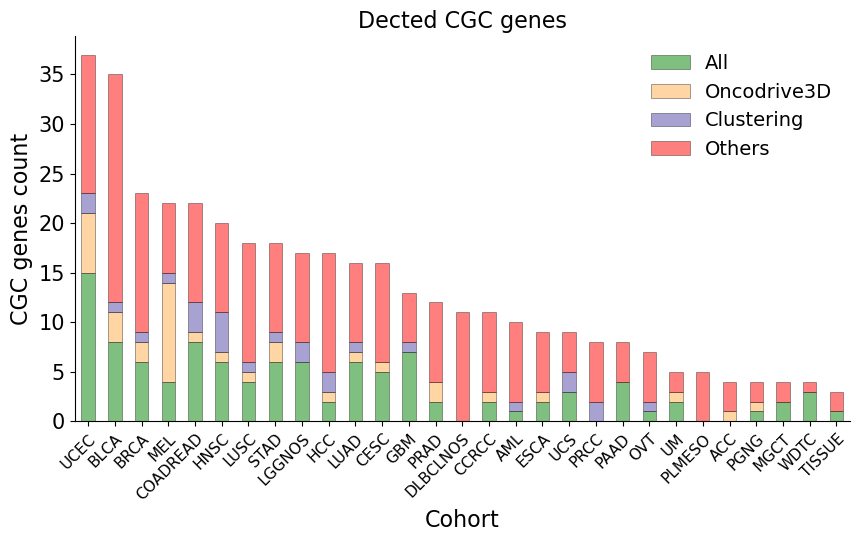

In [69]:
barplot_hits_set_simple(hits_cgc_set_df, 
                        figsize=(10, 5),
                        color_dict=colors, 
                        title='Dected CGC genes', 
                        extract_cancer=True, 
                        xtick_fontsize=11,
                        top_cohorts=29, 
                        ylabel="CGC genes count",
                        save=True,
                        filename=f"{figures}/main/f4/f4d.barplot_tcga_all_methods_cgc.png")

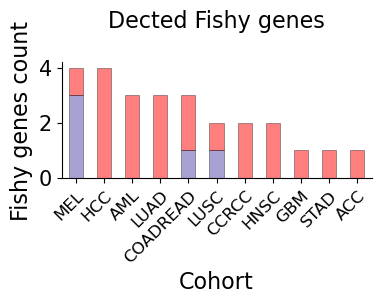

In [70]:
barplot_hits_set_simple(hits_fish_set_df, color_dict=colors, title='Dected Fishy genes\n', 
                 top_cohorts=11, 
                 figsize=(4, 1.5), 
                 legend_ncol=1, 
                 legend_fontsize=8, 
                 extract_cancer=True, 
                 legend=False, 
                 ylabel="Fishy genes count")

### Clustering methods

100%|██████████| 32/32 [00:01<00:00, 18.37it/s]


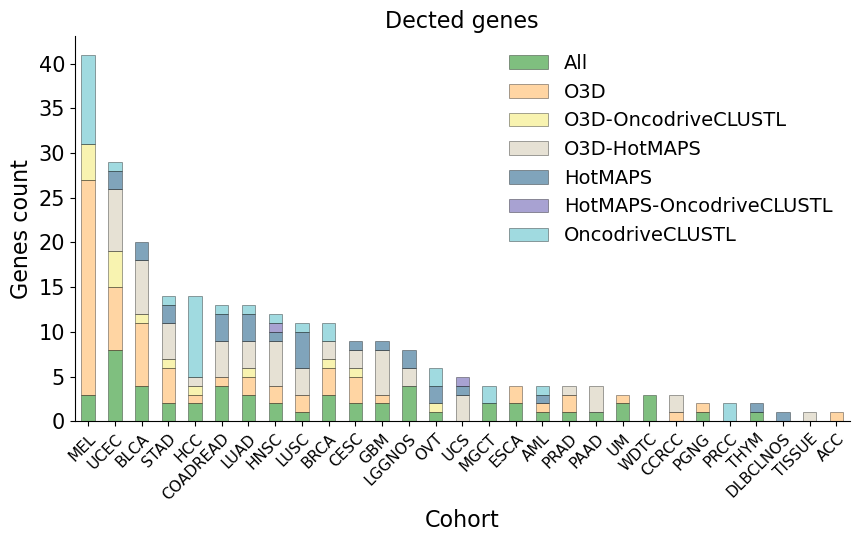

In [71]:
## TCGA
lst_methods = ["o3d", "hotmaps", "clustl", "smreg", "cbase", "dndscv", "mutpan", "fml"]
groups = ["O3D", "HotMAPS", "OncodriveCLUSTL", "O3D-HotMAPS", "O3D-OncodriveCLUSTL", "HotMAPS-OncodriveCLUSTL", "All"]
colors = {"O3D" : colors_dict["Oncodrive3D"],
          "HotMAPS" : colors_dict["HotMAPS"], 
          "OncodriveCLUSTL" : colors_dict["OncodriveCLUSTL"], 
          "O3D-HotMAPS" : "#cec5ab", 
          "O3D-OncodriveCLUSTL" : "#f2e963", 
          "HotMAPS-OncodriveCLUSTL" : "#5247a6", 
          "All" : "green"}

hits_set_df, hits_unknown_set_df, hits_cgc_set_df, hits_fish_set_df = get_hits_set(genetable_subset, groups, lst_methods, clustering_groups=True)
barplot_hits_set_simple(hits_set_df, 
                        color_dict=colors, 
                        figsize=(10, 5),
                        xtick_fontsize=11,
                        title='Dected genes', 
                        extract_cancer=True, 
                        top_cohorts=29,
                        ylabel="Genes count",
                        save=True,
                        filename=f"{figures}/main/f4/f4a.barplot_tcga_clustering_methods.png")

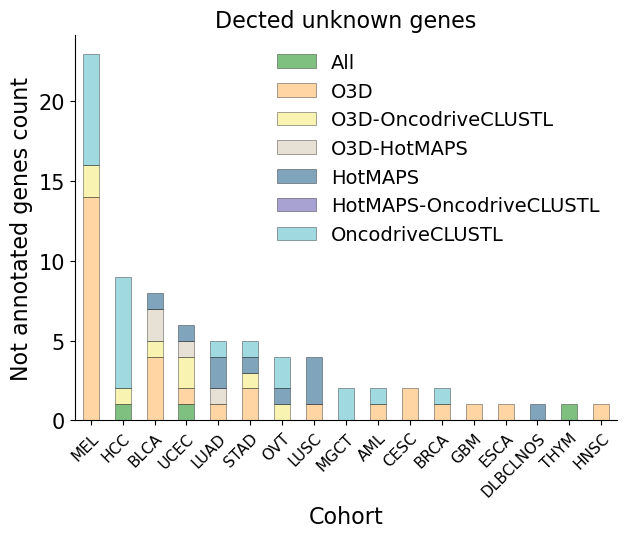

In [72]:
hits_unknown_set_df = hits_unknown_set_df.groupby("Cohort").filter(lambda x: x["Hits"].sum() > 0).reset_index(drop=True)
barplot_hits_set_simple(hits_unknown_set_df, 
                        color_dict=colors, 
                        figsize=(7, 5),
                        xtick_fontsize=11,
                        title='Dected unknown genes', 
                        extract_cancer=True, 
                        top_cohorts=29,
                        ylabel="Not annotated genes count")

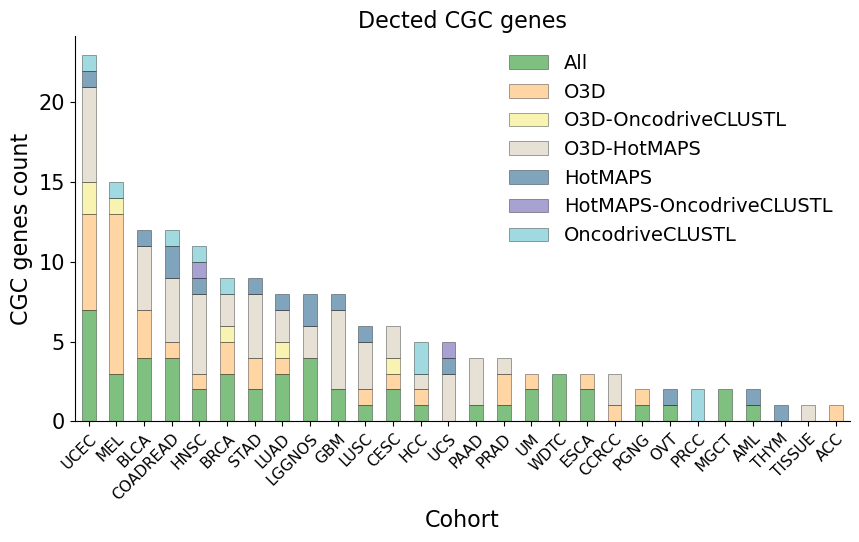

In [73]:
hits_cgc_set_df = hits_cgc_set_df.groupby("Cohort").filter(lambda x: x["Hits"].sum() > 0).reset_index(drop=True)
barplot_hits_set_simple(hits_cgc_set_df, 
                        color_dict=colors, 
                        figsize=(10, 5),
                        xtick_fontsize=11,
                        title='Dected CGC genes', 
                        extract_cancer=True, 
                        top_cohorts=29,
                        ylabel="CGC genes count",
                        save=True,
                        filename=f"{figures}/main/f4/f4b.barplot_tcga_clustering_methods_cgc.png")

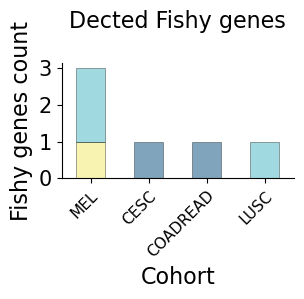

In [74]:
hits_fish_set_df = hits_fish_set_df.groupby("Cohort").filter(lambda x: x["Hits"].sum() > 0).reset_index(drop=True)
barplot_hits_set_simple(hits_fish_set_df, 
                        color_dict=colors, 
                        xtick_fontsize=11,
                        title='Dected Fishy genes\n', 
                        top_cohorts=6, figsize=(3, 1.5), legend_ncol=1, legend_fontsize=8, extract_cancer=True, legend=False,
                        ylabel="Fishy genes count")

## All cohorts grouped by organ

In [75]:
def get_gene_cohort(x, gene_only=False, organ=None):
    
    if gene_only:
        return x['Gene']
    else:
        if organ:
            return f"{x['Gene']}-{organ}"
        else:
            return f"{x['Gene']}-{x['Cohort']}"
        

def get_hits_set_organ(genetable_df, groups, lst_methods, cohort_df, clustering_groups=False, gene_only=True, gene_organ=False):

    lst_df = []
    lst_unknown_df = []
    lst_cgc_df = []
    lst_fish_df = []
    
    for organ in tqdm(cohort_df["GENERAL_CANCER_TYPE"].unique()):
        organ_cohorts = cohort_df.loc[cohort_df["GENERAL_CANCER_TYPE"] == organ, "COHORT"].unique()
        method_organ = genetable_df[genetable_df["Cohort"].isin(organ_cohorts)].copy()
        
        dict_hits = {}
        dict_unknown_hits = {}
        dict_cgc_hits = {}
        dict_fish_hits = {}

        for method in lst_methods:
            method_hits_cohort = method_organ[(method_organ[f"{method}_qval"] < 0.01)]
            dict_hits[method] = set(list(method_hits_cohort.apply(
                lambda x: get_gene_cohort(x, gene_only=gene_only, organ=gene_organ), axis=1).values))
            dict_unknown_hits[method] = set(list(method_hits_cohort[(method_hits_cohort["CGC"] == 0) & 
                                                            (method_hits_cohort["Fish"] == 0)].apply(
                lambda x: get_gene_cohort(x, gene_only=gene_only, organ=gene_organ), axis=1).values))
            dict_cgc_hits[method] = set(list(method_hits_cohort[method_hits_cohort["CGC"] == 1].apply(
                lambda x: get_gene_cohort(x, gene_only=gene_only, organ=gene_organ), axis=1).values))
            dict_fish_hits[method] = set(list(method_hits_cohort[method_hits_cohort["Fish"] == 1].apply(
                lambda x: get_gene_cohort(x, gene_only=gene_only, organ=gene_organ), axis=1).values))

        lst_df.append(get_hits_set_cohort(dict_hits, organ, groups, clustering_groups))
        lst_unknown_df.append(get_hits_set_cohort(dict_unknown_hits, organ, groups, clustering_groups))
        lst_cgc_df.append(get_hits_set_cohort(dict_cgc_hits, organ, groups, clustering_groups))
        lst_fish_df.append(get_hits_set_cohort(dict_fish_hits, organ, groups, clustering_groups))

    hits_set_df = pd.concat(lst_df).reset_index(drop=True)
    hits_unknown_set_df = pd.concat(lst_unknown_df).reset_index(drop=True)
    hits_cgc_set_df = pd.concat(lst_cgc_df).reset_index(drop=True)
    hits_fish_set_df = pd.concat(lst_fish_df).reset_index(drop=True)
    
    return hits_set_df, hits_unknown_set_df, hits_cgc_set_df, hits_fish_set_df

### All methods

100%|██████████| 31/31 [00:03<00:00,  9.63it/s]


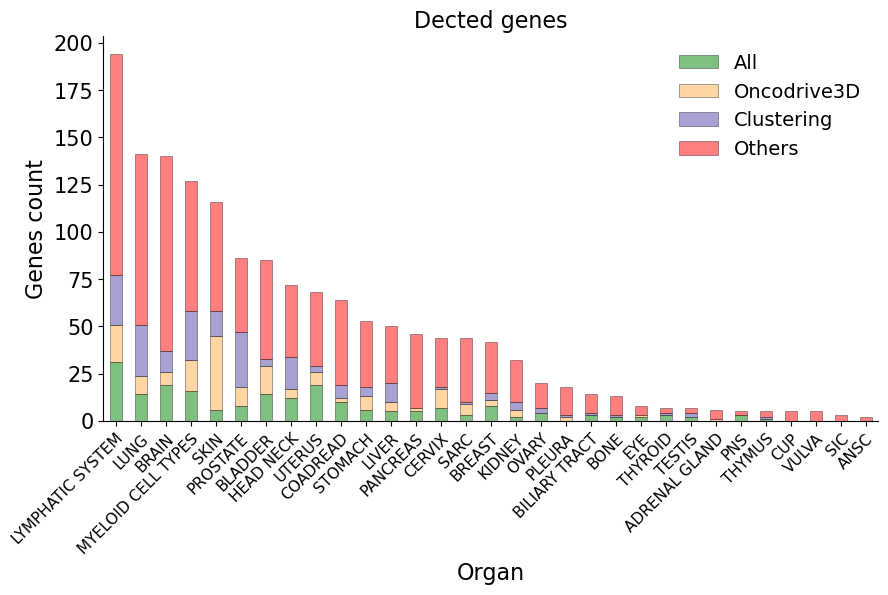

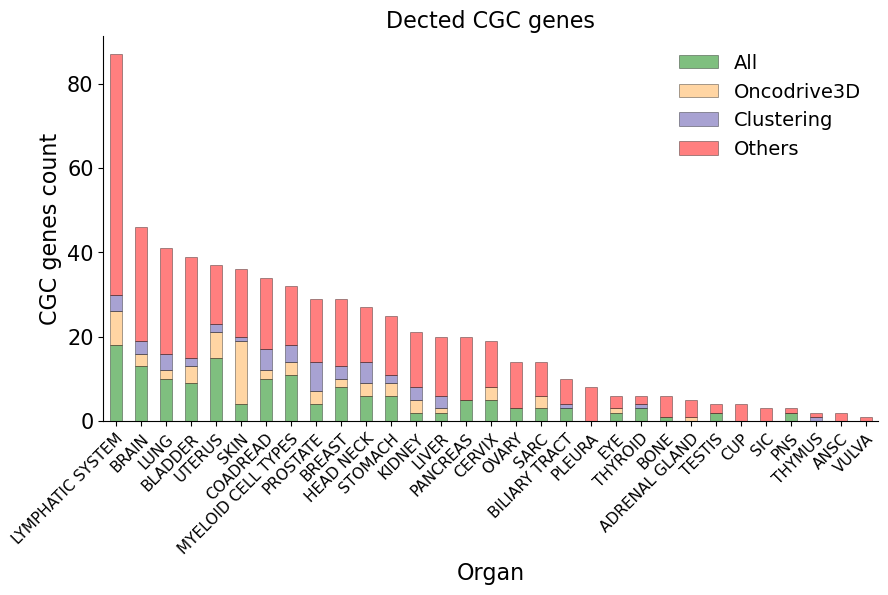

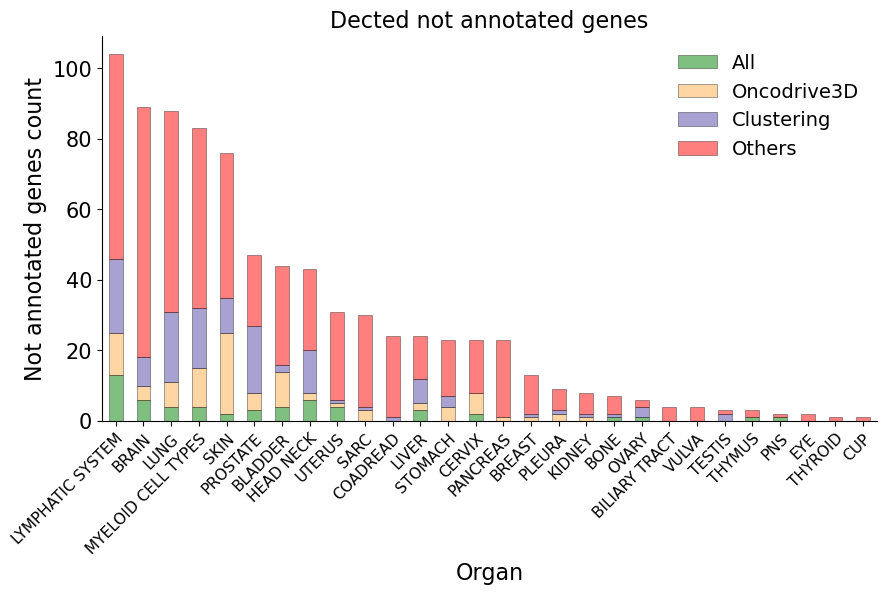

In [76]:
## All cohorts
groups = ["All", "Clustering", "Oncodrive3D", "Others"]
colors = {"Oncodrive3D" : colors_dict[names_dict["o3d"]],
          "Clustering" : "#5247a6", 
          "Others" : "red", 
          "All" : "green"}

hits_set_df, hits_unknown_set_df, hits_cgc_set_df, hits_fish_set_df = get_hits_set_organ(genetable, groups, lst_methods, cohort_df, 
                                                                                         clustering_groups=False, gene_only=True, gene_organ=False)

# All genes
hits_set_df = hits_set_df.groupby("Cohort").filter(lambda x: x["Hits"].sum() > 0).reset_index(drop=True)
hits_set_df.Cohort = hits_set_df.Cohort.str.replace("_", " ")
hits_set_df.Cohort = hits_set_df.Cohort.str.replace("LYMPH", "LYMPHATIC SYSTEM")
hits_set_df.Cohort = hits_set_df.Cohort.str.replace("MYELOID", "MYELOID CELL TYPES")
hits_set_df.Cohort = hits_set_df.Cohort.str.replace("SOFT TISSUE", "SARC")

barplot_hits_set_simple(hits_set_df, 
                        color_dict=colors, 
                        title='Dected genes', 
                        ylabel="Genes count",
                        xlabel="Organ",
                        figsize=(10, 5),
                        xtick_fontsize=11, 
                        plot_xticks=True,
                        save=True,
                        filename=f"{figures}/supplementary/s6/s6c.barplot_all_cohorts_all_methods.png")
# CGC genes
hits_cgc_set_df = hits_cgc_set_df.groupby("Cohort").filter(lambda x: x["Hits"].sum() > 0).reset_index(drop=True)
hits_cgc_set_df.Cohort = hits_cgc_set_df.Cohort.str.replace("_", " ")
hits_cgc_set_df.Cohort = hits_cgc_set_df.Cohort.str.replace("LYMPH", "LYMPHATIC SYSTEM")
hits_cgc_set_df.Cohort = hits_cgc_set_df.Cohort.str.replace("MYELOID", "MYELOID CELL TYPES")
hits_cgc_set_df.Cohort = hits_cgc_set_df.Cohort.str.replace("SOFT TISSUE", "SARC")

barplot_hits_set_simple(hits_cgc_set_df, 
                        color_dict=colors, 
                        title='Dected CGC genes', 
                        ylabel="CGC genes count",
                        xlabel="Organ",
                        figsize=(10, 5),
                        xtick_fontsize=11, 
                        plot_xticks=True,
                        save=True,
                        filename=f"{figures}/supplementary/s6/s6d.barplot_all_cohorts_all_methods_cgc.png")

# Not annotated genes
hits_unknown_set_df = hits_unknown_set_df.groupby("Cohort").filter(lambda x: x["Hits"].sum() > 0).reset_index(drop=True)
hits_unknown_set_df.Cohort = hits_unknown_set_df.Cohort.str.replace("_", " ")
hits_unknown_set_df.Cohort = hits_unknown_set_df.Cohort.str.replace("LYMPH", "LYMPHATIC SYSTEM")
hits_unknown_set_df.Cohort = hits_unknown_set_df.Cohort.str.replace("MYELOID", "MYELOID CELL TYPES")
hits_unknown_set_df.Cohort = hits_unknown_set_df.Cohort.str.replace("SOFT TISSUE", "SARC")

barplot_hits_set_simple(hits_unknown_set_df, 
                        color_dict=colors, 
                        title='Dected not annotated genes', 
                        ylabel="Not annotated genes count",
                        xlabel="Organ",
                        figsize=(10, 5),
                        xtick_fontsize=11, 
                        plot_xticks=True,
                        save=True,
                        filename=f"{figures}/supplementary/s11/s11a.hits_barplot_organ_unique_unknown.png")

### Clustering methods

100%|██████████| 31/31 [00:03<00:00, 10.17it/s]


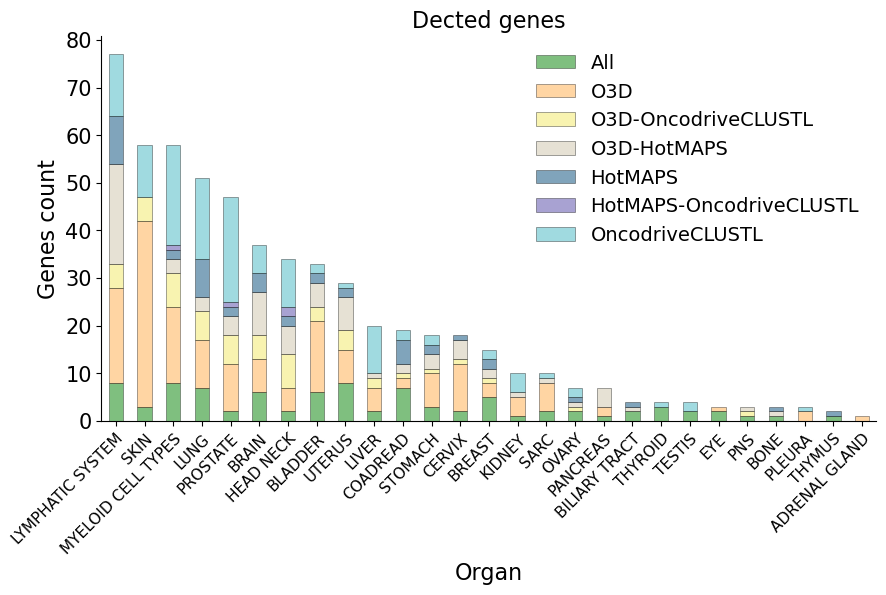

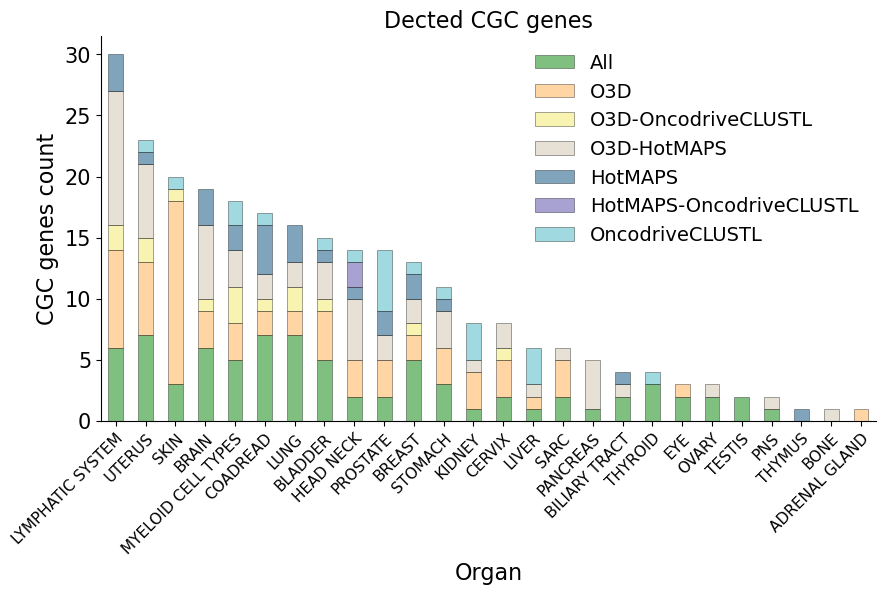

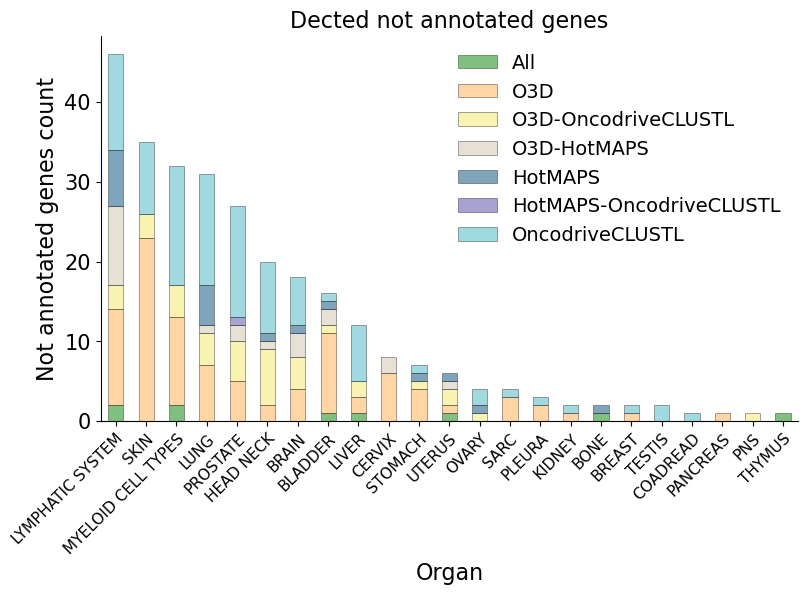

In [77]:
## All cohorts
groups = ["O3D", "HotMAPS", "OncodriveCLUSTL", "O3D-HotMAPS", "O3D-OncodriveCLUSTL", "HotMAPS-OncodriveCLUSTL", "All"]
colors = {"O3D" : colors_dict["Oncodrive3D"],
          "HotMAPS" : colors_dict["HotMAPS"], 
          "OncodriveCLUSTL" : colors_dict["OncodriveCLUSTL"], 
          "O3D-HotMAPS" : "#cec5ab", 
          "O3D-OncodriveCLUSTL" : "#f2e963", 
          "HotMAPS-OncodriveCLUSTL" : "#5247a6", 
          "All" : "green"}

hits_set_df, hits_unknown_set_df, hits_cgc_set_df, hits_fish_set_df = get_hits_set_organ(genetable, groups, lst_methods, cohort_df, 
                                                                                         clustering_groups=True, gene_only=True, gene_organ=False)

# All genes
hits_set_df = hits_set_df.groupby("Cohort").filter(lambda x: x["Hits"].sum() > 0).reset_index(drop=True)
hits_set_df.Cohort = hits_set_df.Cohort.str.replace("_", " ")
hits_set_df.Cohort = hits_set_df.Cohort.str.replace("LYMPH", "LYMPHATIC SYSTEM")
hits_set_df.Cohort = hits_set_df.Cohort.str.replace("MYELOID", "MYELOID CELL TYPES")
hits_set_df.Cohort = hits_set_df.Cohort.str.replace("SOFT TISSUE", "SARC")

barplot_hits_set_simple(hits_set_df, 
                        color_dict=colors, 
                        title='Dected genes', 
                        ylabel="Genes count",
                        xlabel="Organ",
                        figsize=(10, 5),
                        xtick_fontsize=11, 
                        plot_xticks=True,
                        save=True,
                        filename=f"{figures}/supplementary/s6/s6a.barplot_all_cohorts_clustering_methods.png")

# CGC genes
hits_cgc_set_df = hits_cgc_set_df.groupby("Cohort").filter(lambda x: x["Hits"].sum() > 0).reset_index(drop=True)
hits_cgc_set_df.Cohort = hits_cgc_set_df.Cohort.str.replace("_", " ")
hits_cgc_set_df.Cohort = hits_cgc_set_df.Cohort.str.replace("LYMPH", "LYMPHATIC SYSTEM")
hits_cgc_set_df.Cohort = hits_cgc_set_df.Cohort.str.replace("MYELOID", "MYELOID CELL TYPES")
hits_cgc_set_df.Cohort = hits_cgc_set_df.Cohort.str.replace("SOFT TISSUE", "SARC")

barplot_hits_set_simple(hits_cgc_set_df, 
                        color_dict=colors, 
                        title='Dected CGC genes', 
                        ylabel="CGC genes count",
                        xlabel="Organ",
                        figsize=(10, 5),
                        xtick_fontsize=11, 
                        plot_xticks=True,
                        save=True,
                        filename=f"{figures}/supplementary/s6/s6b.barplot_all_cohorts_clustering_methods_cgc.png")

# Not annotated genes
hits_unknown_set_df = hits_unknown_set_df.groupby("Cohort").filter(lambda x: x["Hits"].sum() > 0).reset_index(drop=True)
hits_unknown_set_df.Cohort = hits_unknown_set_df.Cohort.str.replace("_", " ")
hits_unknown_set_df.Cohort = hits_unknown_set_df.Cohort.str.replace("LYMPH", "LYMPHATIC SYSTEM")
hits_unknown_set_df.Cohort = hits_unknown_set_df.Cohort.str.replace("MYELOID", "MYELOID CELL TYPES")
hits_unknown_set_df.Cohort = hits_unknown_set_df.Cohort.str.replace("SOFT TISSUE", "SARC")

barplot_hits_set_simple(hits_unknown_set_df, 
                        color_dict=colors, 
                        title='Dected not annotated genes', 
                        ylabel="Not annotated genes count",
                        xlabel="Organ",
                        figsize=(9, 5),
                        xtick_fontsize=11, 
                        plot_xticks=True)

# 3) F2, S2, S11: Number of detected genes

## Total number

In [10]:
if "random" in lst_methods:
    lst_methods.remove("random")

In [9]:
def ema_smooth(scalars, weight):
    """
    EMA implementation according to
    https://github.com/tensorflow/tensorboard/blob/34877f15153e1a2087316b9952c931807a122aa7/tensorboard/components/vz_line_chart2/line-chart.ts#L699
    
    NB: copied from stack-overflow
    """
    
    last = 0
    smoothed = []
    num_acc = 0
    for next_val in scalars:
        last = last * weight + (1 - weight) * next_val
        num_acc += 1
        # de-bias
        debias_weight = 1
        if weight != 1:
            debias_weight = 1 - math.pow(weight, num_acc)
        smoothed_val = last / debias_weight
        smoothed.append(smoothed_val)

    return smoothed


def get_zorder(col):
    """
    Prioritize order of the clustering methods
    """
    
    if col == "o3d":
            zorder = 3
    elif col == "hotmaps":
        zorder = 2
    elif col == "clustl":
        zorder = 1
    else:
        zorder = 0
        
    return zorder
    

def get_count(df_sum, method, annotation, overlap, unique=False):
    
    if unique:
        return df_sum[(df_sum["Method"] == f"{method}") & (df_sum["Gene"] == annotation) & (df_sum["Overlap"] == overlap)].Count.values[0]
        
    return df_sum[(df_sum["Method"] == f"{method}") & (df_sum["Gene"] == annotation) & (df_sum["Overlap"] == overlap)].Count.values[0]


def get_unique_hits(df, qval_lst_name, df_to_exclude=None):
    
    # Initialize a dictionary to store the sums
    sums_by_method = {}

    # Iterate through each q-value column
    for column in qval_lst_name:
        # Filter rows where the p-value is lower than 0.01 and drop duplicates in the 'Gene' column
        method_df = df[df[column] < 0.01].drop_duplicates(subset='Gene')

        # Remove genes that are already counted to avoid counting them twice
        if df_to_exclude is not None:
            method_genes_to_exclude = df_to_exclude[df_to_exclude[column] < 0.01].Gene.unique()
            ix_filter = ~method_df.Gene.isin(method_genes_to_exclude)
            method_df = method_df[ix_filter]

        # Store the sum in the dictionary with the method name as the key
        sums_by_method[column] = len(method_df)
        
    return pd.DataFrame(sums_by_method, index=[0])
    

def get_hits_summary(cohort_df, 
                     lst_name, 
                     alpha = 0.01, 
                     unknown = True, 
                     unique = False, 
                     df_to_exclude = None):
    """
    Get the count of significant genes for each method 
    for both p-values and q-values, all genes and CGC genes.
    """

    # Get qvals hits, CGC, and Fishy count
    
    qval_lst_name = [f"{name}_qval" for name in lst_name]
    
    if unique:
        cohort_hits_cgc = cohort_df[(cohort_df["CGC"] == 1)]
        qval_hits_cgc = get_unique_hits(cohort_hits_cgc, qval_lst_name, df_to_exclude)
        qval_hits_cgc.columns = [f"{col}_cgc" for col in qval_hits_cgc.columns]

        cohort_hits_fish = cohort_df[(cohort_df["Fish"] == 1)]
        qval_hits_fish = get_unique_hits(cohort_hits_fish, qval_lst_name, df_to_exclude)
        qval_hits_fish.columns = [f"{col}_fish" for col in qval_hits_fish.columns]

        df_to_exclude = pd.concat((df_to_exclude, cohort_hits_fish))
        if unknown:
            cohort_df_no_annot = cohort_df[(cohort_df["CGC"] == 0) & (cohort_df["Fish"] == 0)]
            qval_hits = get_unique_hits(cohort_df_no_annot, qval_lst_name, df_to_exclude)
        else:
            qval_hits = get_unique_hits(cohort_df, qval_lst_name, df_to_exclude)
        
        return pd.concat((qval_hits, qval_hits_cgc, qval_hits_fish), axis=1)
    
    else:
        if unknown:
            cohort_df_no_annot = cohort_df[(cohort_df["CGC"] == 0) & (cohort_df["Fish"] == 0)]
            qval_hits = cohort_df_no_annot[[s for s in qval_lst_name if s in cohort_df.columns]].apply(lambda x: x < alpha).sum()
        else:
            qval_hits = cohort_df[[s for s in qval_lst_name if s in cohort_df.columns]].apply(lambda x: x < alpha).sum()
        qval_hits_cgc = cohort_df[[s for s in qval_lst_name if s in cohort_df.columns]].apply(lambda x: cohort_df.loc[x < alpha, "CGC"]).sum()
        qval_hits_cgc.index = [f"{i}_cgc" for i in qval_hits_cgc.index]
        qval_hits_fish = cohort_df[[s for s in qval_lst_name if s in cohort_df.columns]].apply(lambda x: cohort_df.loc[x < alpha, "Fish"]).sum()
        qval_hits_fish.index = [f"{i}_fish" for i in qval_hits_fish.index]
        
        return pd.DataFrame(pd.concat((qval_hits, qval_hits_cgc, qval_hits_fish))).T


def get_hits_summary_lst_cohorts(genetable,
                                 lst_name,
                                 overlaps_all = False,
                                 alpha = 0.01,
                                 unknown = True,
                                 unique = False,
                                 df_to_exclude = None):
    """
    Get count of significant genes (pvals and qvals) and 
    count and ratio of significant genes in CGC across 
    each method and all provided cohorts.
    """
    
    # Get sum of unique genes across all cohorts
    if unique:
        hits_df = get_hits_summary(genetable, lst_name, alpha = alpha, unknown = unknown, unique = True, df_to_exclude = df_to_exclude)
        hits_df.insert(0, "Cohort", "All_cohorts")
        
        return hits_df
    
    # Get sum of genes-cohorts
    else:
        lst_cohort_result = []
        for cohort in tqdm(genetable.Cohort.unique()):

            table_df = genetable[genetable["Cohort"] == cohort]

            if len(table_df) > 0:

                # Get hits summary table
                hits_df = get_hits_summary(table_df, lst_name, alpha = alpha, unknown = unknown, unique = False)
                hits_df.insert(0, "Cohort", cohort)
                lst_cohort_result.append(hits_df)
        
        if len(lst_cohort_result) > 0:
            return pd.concat(lst_cohort_result).reset_index(drop=True)


def get_sum_by_annotation(hits_df, lst_name, unknown=True):

    df = hits_df.copy()
    cols = [f"{name}_qval" for name in lst_name]
    cols_cgc = [f"{name}_qval_cgc" for name in lst_name]
    cols_fish = [f"{name}_qval_fish" for name in lst_name]
        
    df_sum = pd.DataFrame(df[cols].sum()).reset_index().rename(columns = {"index" : "Method", 0 : "Count"})
    if unknown:
        df_sum["Gene"] = "Not annotated"
    else:
        df_sum["Gene"] = "Any"
    
    df_sum_cgc = df[cols_cgc].sum()
    df_sum_cgc.index = cols
    df_sum_cgc = pd.DataFrame(df_sum_cgc).reset_index().rename(columns = {"index" : "Method", 0 : "Count"})
    df_sum_cgc["Gene"] = "CGC"

    df_sum_fish = df[cols_fish].sum()
    df_sum_fish.index = cols
    df_sum_fish = pd.DataFrame(df_sum_fish).reset_index().rename(columns = {"index" : "Method", 0 : "Count"})
    df_sum_fish["Gene"] = "Fish"

    df_sum = pd.concat((df_sum, df_sum_cgc, df_sum_fish))
    
    return df_sum


def plot_hits_barplot(genetable_df, lst_name, dict_name, 
                      figsize=(9, 5), 
                      sort=True, 
                      legend_box=(0.45, 1.05),
                      unknown=True,
                      vspace_annotation=18,
                      title=None,
                      unique=False,
                      filename="hits_stacked_barplot.png",
                      fontsize_annotation=14):

    genetable = genetable_df.copy()
    cols = [f"{name}_qval" for name in lst_name]
    cols_cgc = [f"{name}_qval_cgc" for name in lst_name]
    cols_fish = [f"{name}_qval_fish" for name in lst_name]

    # Get sum df
    pval_cols = [f"{col}_pval" for col in lst_methods]
    genetable_overlap = genetable.dropna(subset=[f"{col}_pval" for col in lst_methods])
    genetable_no_overlap = genetable[genetable[pval_cols].isna().any(axis=1)]
    
    hits_df_overlap = get_hits_summary_lst_cohorts(genetable_overlap, 
                                                   lst_methods, 
                                                   unknown=unknown, 
                                                   unique=unique)
    hits_df_no_overlap = get_hits_summary_lst_cohorts(genetable_no_overlap, 
                                                      lst_methods, 
                                                      unknown=unknown, 
                                                      unique=unique, 
                                                      df_to_exclude=genetable_overlap if unique else None)
    
    df_sum_overlap = get_sum_by_annotation(hits_df_overlap, lst_methods, unknown=unknown)
    df_sum_no_overlap = get_sum_by_annotation(hits_df_no_overlap, lst_methods, unknown=unknown)
    df_sum_overlap["Overlap"] = "Yes"
    df_sum_no_overlap["Overlap"] = "No"

    df_sum = pd.concat((df_sum_overlap, df_sum_no_overlap)).reset_index(drop=True)    
        
    # Get counts by annotation and overlap for each method
    if unknown:
        unknown_annotation = "Not annotated"
    else:
        unknown_annotation = "Any"
    if sort:
        lst_name = list(df_sum[df_sum["Gene"] == "CGC"].groupby("Method").sum().sort_values(by=["Count"], ascending=False).index)
    cgc = np.array([get_count(df_sum, method, annotation="CGC", overlap="Yes") for method in lst_name])
    cgc_no_overlap = np.array([get_count(df_sum, method, annotation="CGC", overlap="No") for method in lst_name])
    fish = np.array([get_count(df_sum, method, annotation="Fish", overlap="Yes") for method in lst_name])
    fish_no_overlap = np.array([get_count(df_sum, method, annotation="Fish", overlap="No") for method in lst_name])
    unknown = np.array([get_count(df_sum, method, annotation=unknown_annotation, overlap="Yes") for method in lst_name])
    unknown_no_overlap = np.array([get_count(df_sum, method, annotation=unknown_annotation, overlap="No") for method in lst_name])

    barplot_hits_stacked_dodge(unknown, unknown_no_overlap,
                               cgc, cgc_no_overlap,
                               fish, fish_no_overlap,
                               lst_name,
                               dict_name,
                               unknown_annotation,
                               figsize=figsize,
                               legend_box=legend_box,
                               vspace_annotation=vspace_annotation,
                               title=title,
                               fontsize_annotation=fontsize_annotation,
                               unique=unique,
                               filename=filename)


def barplot_hits_stacked_dodge(unknown, unknown_no_overlap,
                               cgc, cgc_no_overlap,
                               fish, fish_no_overlap,
                               lst_name,
                               dict_name,
                               unknown_annotation="Not annotated",
                               figsize=(10, 5), 
                               legend_box=(0.45, 1.05),
                               vspace_annotation=18,
                               fontsize_annotation=14,
                               title=None,
                               unique=False,
                               filename=None):

    lst_all_values = unknown, unknown_no_overlap, cgc, cgc_no_overlap, fish, fish_no_overlap
    n_methods = len(unknown)

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    plt.figure(figsize=figsize)
    with sns.axes_style("white"):
        sns.set_context("talk")   
        sns.set_style("ticks")

        # Plot details
        bar_width = 0.3
        epsilon = .005
        line_width = 1
        unknown_bar_positions = np.arange(len(unknown))
        cgc_bar_positions = unknown_bar_positions + bar_width
        fish_bar_positions = cgc_bar_positions + bar_width

        # Bar plots
        ax = plt.gca()
        unknown_bar = plt.bar(unknown_bar_positions, unknown, bar_width,
                              color="lightgray",
                              label=unknown_annotation)
        unknown_bar = plt.bar(unknown_bar_positions, unknown_no_overlap, bar_width-epsilon,
                              bottom=unknown,
                              color="lightgray",
                              edgecolor='white',
                              linewidth=line_width,
                              hatch='//')

        cgc_bar = plt.bar(cgc_bar_positions, cgc, bar_width,
                               color=colors[1],
                               label='CGC')
        cgc_bar = plt.bar(cgc_bar_positions, cgc_no_overlap, bar_width-epsilon,
                               bottom=cgc,
                               color=colors[1],
                               hatch='//',
                               edgecolor='white',
                               linewidth=line_width+0.5)

        fish_bar = plt.bar(fish_bar_positions, fish, bar_width,
                               color=colors[2],
                               label='Fishy')
        fish_bar = plt.bar(fish_bar_positions, fish_no_overlap, bar_width-epsilon,
                               bottom=fish,
                               color=colors[2],
                               hatch='//',
                               edgecolor='white',
                               linewidth=line_width+0.5)

        # Add annotations on top of each bar
        up = 1, 3, 5, 7
        down = 0, 2, 4, 6 
        max_sum_bar = 0

        for i, p in enumerate(ax.patches):

            method_ix = i%n_methods
            label_ix = int(i / n_methods)

            if label_ix%2 > 0:
                n=-1
            else:
                n=1

            sum_bar = lst_all_values[label_ix][method_ix] + lst_all_values[label_ix+n][method_ix]

            if label_ix in up:
                pass
                #sum_bar += vspace_annotation
            else:
                continue

            if sum_bar > max_sum_bar:
                max_sum_bar = sum_bar

            ax.annotate(format(sum_bar, '.0f'),                
                        (p.get_x() + p.get_width() / 2., sum_bar),
                        ha = 'center', va = 'center',
                        xytext = (0, 10),
                        textcoords = 'offset points',
                        fontsize=fontsize_annotation)

        handles, labels = ax.get_legend_handles_labels()
        handles.append(mpatches.Patch(facecolor='white', edgecolor='black', label='Processed by all methods'))
        handles.append(mpatches.Patch(facecolor='white', edgecolor='black', hatch='//', label="Processed by a subset of methods"))

        if unique:
            plt.ylabel("Unique genes count", fontsize = 16)
        else:
            plt.ylabel("Gene-cohort count", fontsize = 16)

        plt.yticks(fontsize=15)      
        plt.xticks((unknown_bar_positions+cgc_bar_positions+fish_bar_positions)/3, 
                   [dict_name[name.split("_")[0]] for name in lst_name], 
                   rotation=45, 
                   fontsize=14,
                   rotation_mode="anchor", 
                   ha='right')
        plt.legend(handles=handles, bbox_to_anchor=legend_box, fontsize=14, frameon=False)
        plt.title(title, fontsize=16)
        sns.despine()
        ax.spines['left'].set_linewidth(1) 
        ax.spines['bottom'].set_linewidth(1) 
        ax.tick_params(axis='both', which='both', width=1)
        if filename is not None:
            plt.savefig(filename, dpi=900, bbox_inches='tight')
        plt.show()


def plot_hits_summary(df, name_dic, color_dic,
                      smooth = False, ema_w = 0.7,
                      figsize = (17, 8), legend_fontsize = 12, legend_ncol = 1,
                      title = None, 
                      style = "o-",
                      plot_xticks = False, 
                      extract_cancer = False,
                      rm_zero_rows = True,
                      legend_box = (1, 1),
                      filename=None,
                      ylabel="Genes count",
                      target="Cohort"):
       
    plt.rcdefaults()
    df = df.copy()
    if extract_cancer:
        df["Cohort"] = df["Cohort"].apply(lambda x: x.split("_")[len(x.split("_"))-1])
    df = df.set_index(target)

    if rm_zero_rows:
        df = df[~(df == 0).all(axis=1)]
        
    # Sort cohorts by total across methods 
    cols = df.columns
    df["Total"] = df.iloc[:, 1:].sum(axis = 1)
    df = df.sort_values("Total", ascending=False).drop(columns = ["Total"])
    
    # Compute average of each method then drop NA
    methods_sum = df.sum(numeric_only = True)
    methods_sum.index = cols
    df = df[~df.isna().any(axis=1)]
    
    # Plot
    plt.figure(figsize = figsize)
    
    # Sort cols
    cols_avg = np.mean(df, axis=0)
    cols_order = np.argsort(cols_avg)[::-1]
    df = df.iloc[:, cols_order]

    for col in df.columns:
        if smooth:
            y = ema_smooth(df[col], ema_w)     
        else: 
            y = df[col]
        method_name = name_dic[col.split("_")[0]]
        
        if method_name in ["HotMAPS", "Oncodrive3D", "OncodriveCLUSTL", "Random"]:
            alpha=1
            #label = f"{method_name} (Sum = {int(methods_sum[col])})"
            label = f"{method_name}"
        else:
            alpha=0.7
            label = None
            label = f"{method_name}"
        
        plt.plot(df.index, y, style, color = color_dic[method_name], label = label, zorder = get_zorder(col.split("_")[0]), alpha=alpha)
        
    # Plot details
    plt.legend(fontsize = legend_fontsize, ncol = legend_ncol, bbox_to_anchor=legend_box, frameon=False)
    if plot_xticks:    
        plt.xticks(rotation=45, rotation_mode="anchor", ha='right', fontsize=10) 
    else:
        plt.xticks([])
    plt.yticks(fontsize=15)
    plt.ylabel(ylabel, fontsize = 16)
    plt.xlabel(target, fontsize = 16)
    plt.xticks(fontsize=11)
    
    plt.title(title, fontsize = 15)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    if filename is not None:
        plt.savefig(filename, dpi=900, bbox_inches='tight')
    plt.show()

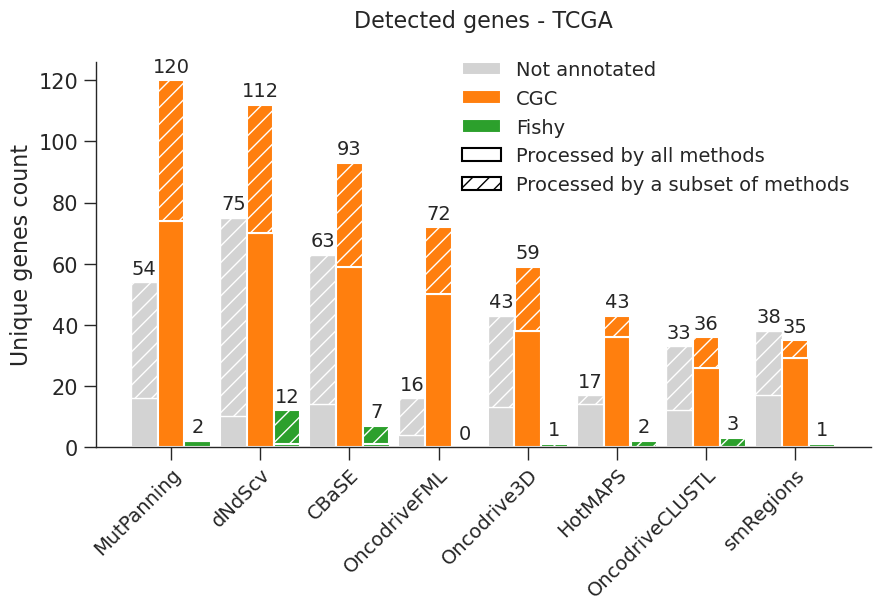

100%|██████████| 32/32 [00:01<00:00, 24.24it/s]


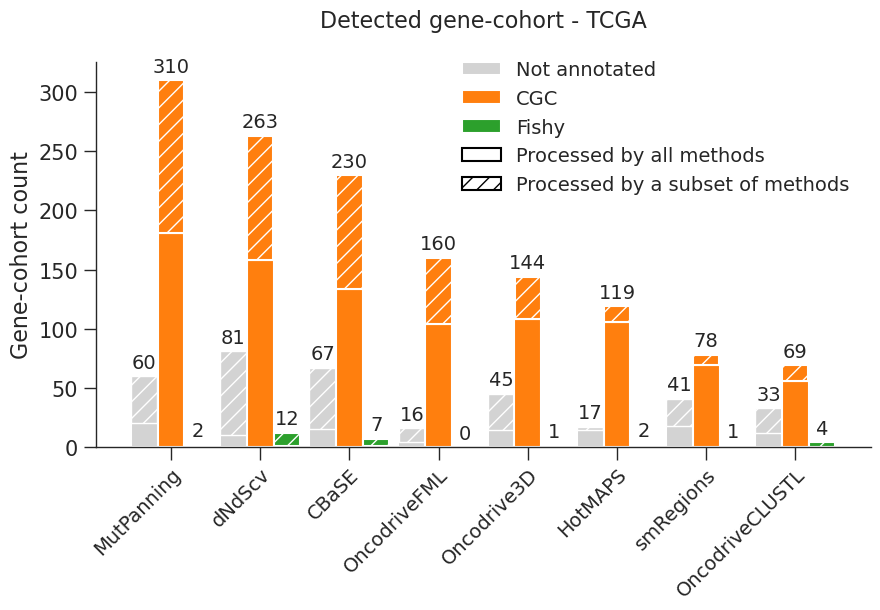

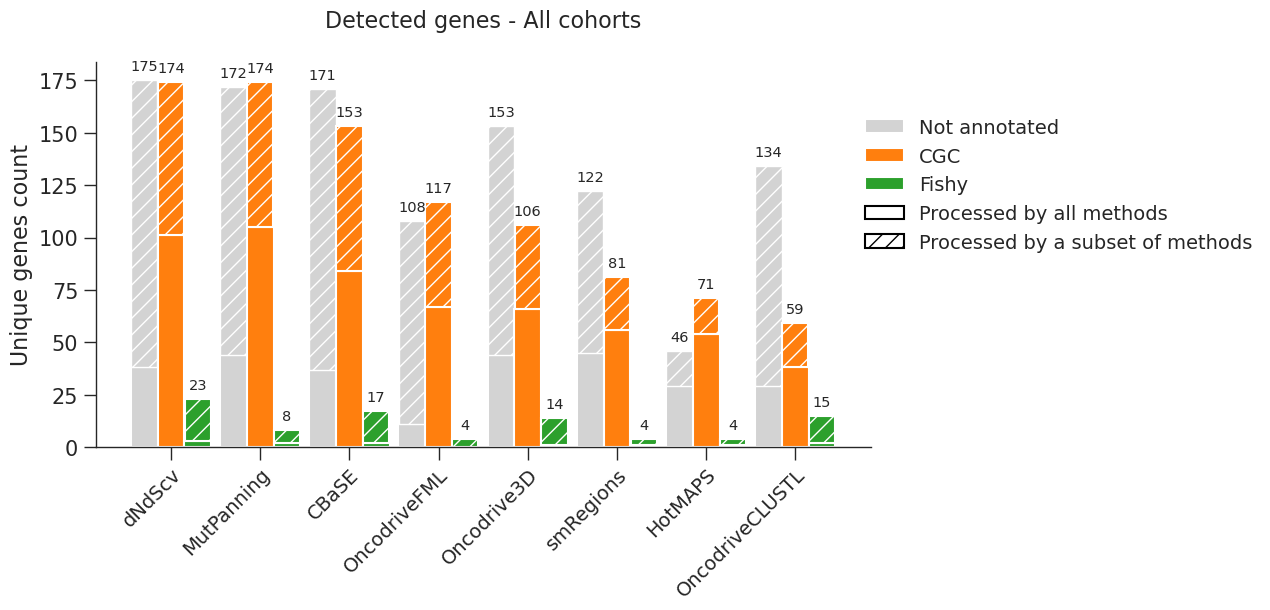

100%|██████████| 214/214 [00:45<00:00,  4.67it/s]


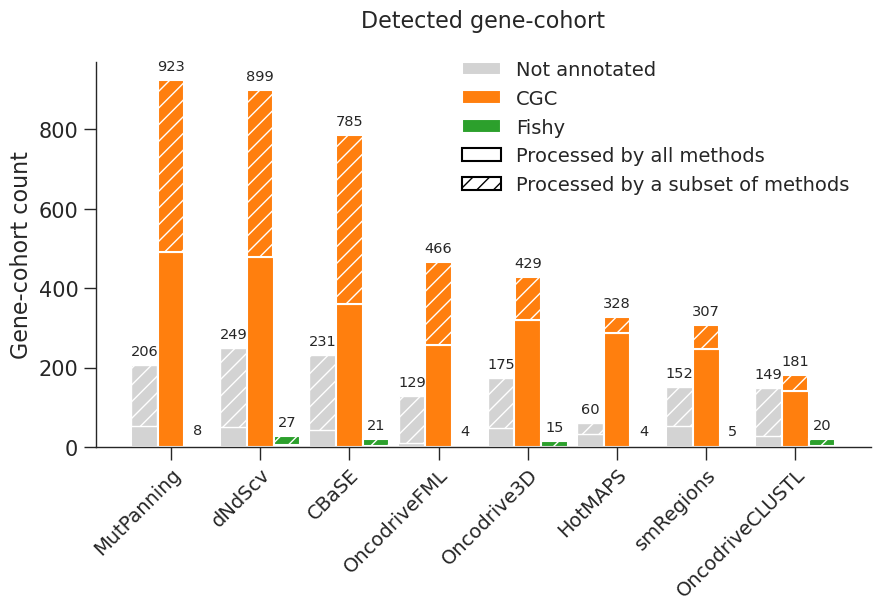

In [80]:
# TCGA - Unique genes
plot_hits_barplot(genetable_subset, lst_methods, names_dict, unique=True, title="Detected genes - TCGA\n", 
                  fontsize_annotation=14, figsize=(10,5),
                  filename=f"{figures}/main/f2/f2d.hits_barplot_tcga_unique.png")

# TCGA - All genes
plot_hits_barplot(genetable_subset, lst_methods, names_dict, figsize=(10,5),
                  title="Detected gene-cohort - TCGA\n",
                  filename=None,
                  fontsize_annotation=14)

# All cohorts - Unique genes
plot_hits_barplot(genetable, lst_methods, names_dict, unique=True,
                  fontsize_annotation=10.5, figsize=(10,5),
                  title="Detected genes - All cohorts\n", legend_box=(0.97, 0.9),
                  filename=f"{figures}/supplementary/s2/s2c.hits_stacked_barplot_unique_genes.png")

# All cohorts - All genes
plot_hits_barplot(genetable, lst_methods, names_dict, vspace_annotation=50, 
                  fontsize_annotation=10.5, figsize=(10,5),
                  title="Detected gene-cohort\n",
                  filename=f"{figures}/supplementary/s2/s2d.hits_stacked_barplot_gene_cohort.png")

## Number by cohort

### TCGA

100%|██████████| 32/32 [00:01<00:00, 22.74it/s]


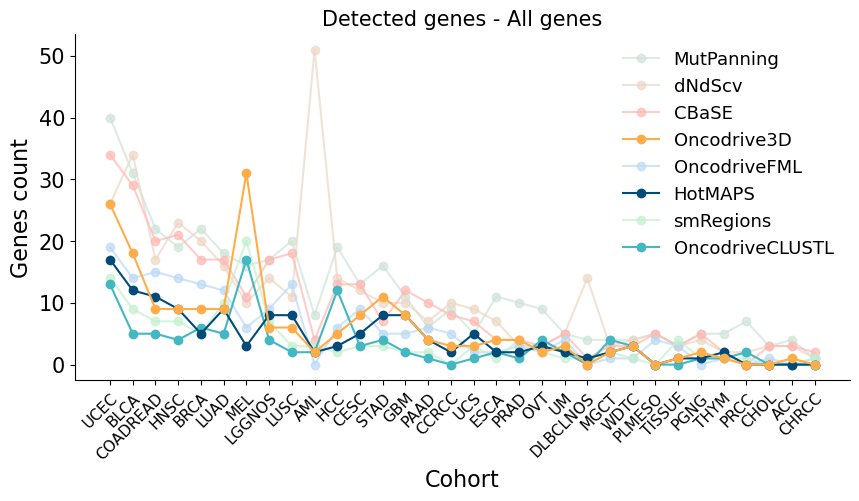

In [15]:
# TCGA colored
# ============

# Names and colors

colors_dic = {"Oncodrive3D" : "#ffad48", 
              "HotMAPS" : "#024b79", 
              "OncodriveCLUSTL" : "#43b7c2", 
              "smRegions" : "#c2f1ce", 
              "CBaSE" : "#ffb8b3", 
              "SEISMIC" : "#ede5ff", 
              "dNdScv" : "#edd7c5", 
              "MutPanning" : "#cee4d8", 
              "OncodriveFML" : "#bbd9f6",
              "Random" : "pink"}

names_dic = {"o3d" : "Oncodrive3D", 
             "hotmaps" : "HotMAPS", 
             "clustl" : "OncodriveCLUSTL", 
             "smreg" : "smRegions", 
             "cbase" : "CBaSE", 
             "seismic" : "SEISMIC", 
             "dndscv" : "dNdScv", 
             "mutpan" : "MutPanning", 
             "fml" : "OncodriveFML",
             "random" : "Random"}

## TCGA
df = genetable_subset.copy()
hits_df = get_hits_summary_lst_cohorts(df, lst_methods, unknown=False, unique=False)

# All genes
cols = [f"{name}_qval" for name in lst_methods]
plot_hits_summary(hits_df[["Cohort"] + cols], 
                  names_dic, colors_dic,
                  smooth = False, 
                  figsize = (10, 4.5), 
                  title = "Detected genes - All genes", 
                  plot_xticks=True, 
                  rm_zero_rows=False, 
                  extract_cancer=True, 
                  ylabel="Genes count",
                  legend_fontsize = 13)

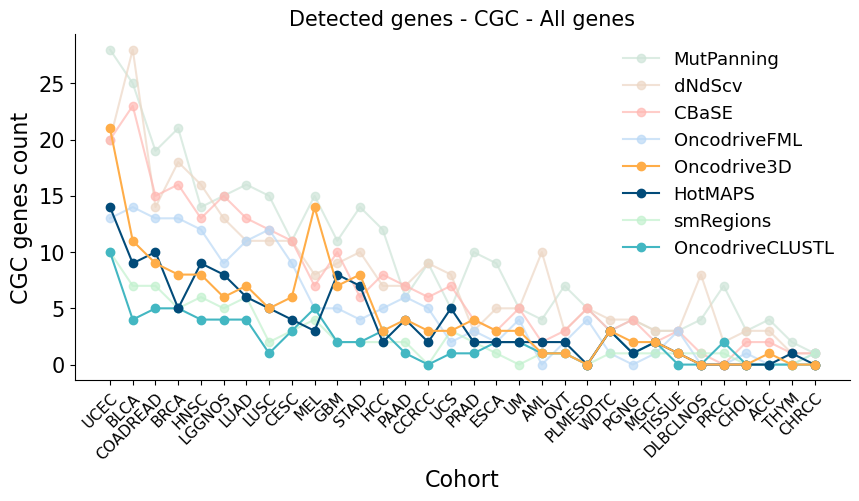

In [17]:
# CGC

cols = [f"{name}_qval_cgc" for name in lst_methods]
plot_hits_summary(hits_df[["Cohort"] + cols], names_dic, colors_dic,
                  smooth = False, figsize = (10, 4.5), title = "Detected genes - CGC - All genes", 
                  plot_xticks=True, rm_zero_rows=False, extract_cancer=True, legend_fontsize = 13,
                  ylabel="CGC genes count",
                  filename=f"{figures}/main/f2/f2d.hits_scatter_tcga_cgc.png")

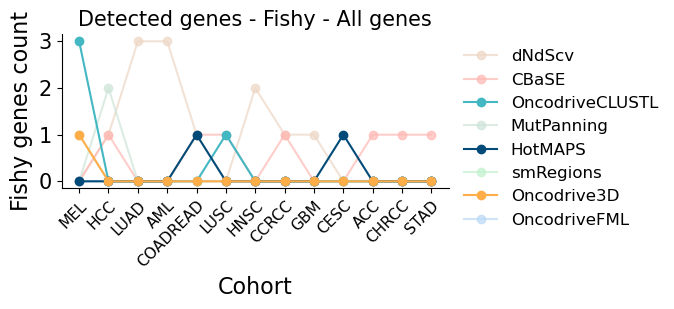

In [13]:
# Fish

cols = [f"{name}_qval_fish" for name in lst_methods]
plot_hits_summary(hits_df[["Cohort"] + cols], names_dic, colors_dic,
                  smooth = False, figsize = (5, 2), title = "Detected genes - Fishy - All genes", 
                  plot_xticks=True, rm_zero_rows=True, extract_cancer=True,
                  ylabel="Fishy genes count")

100%|██████████| 32/32 [00:01<00:00, 18.77it/s]


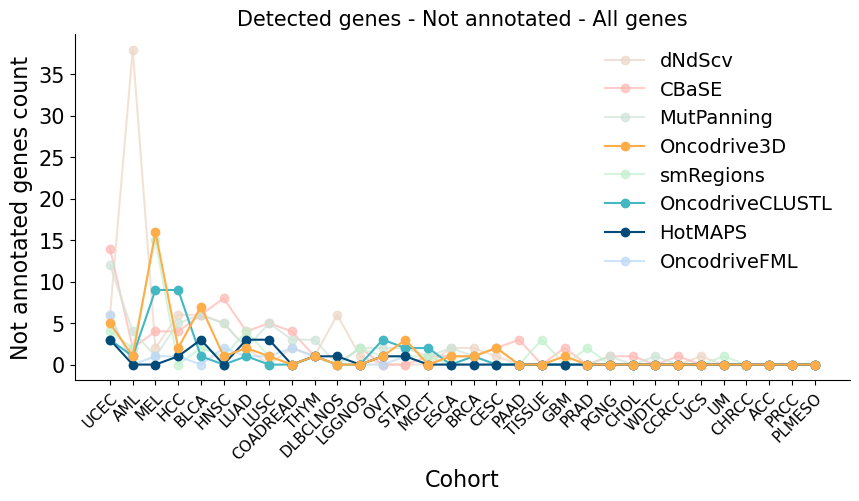

In [14]:
df = genetable_subset.copy()
hits_df = get_hits_summary_lst_cohorts(df, lst_methods, unknown=True, unique=False)

# Not annotated

cols = [f"{name}_qval" for name in lst_methods]
plot_hits_summary(hits_df[["Cohort"] + cols], 
                  names_dic, colors_dic,
                  smooth = False, 
                  figsize = (10, 4.5), 
                  title = "Detected genes - Not annotated - All genes", 
                  plot_xticks=True, 
                  rm_zero_rows=False, 
                  extract_cancer=True, 
                  ylabel="Not annotated genes count",
                  legend_fontsize = 13)

### All cohorts - Organs

In [85]:
def get_hits_summary_lst_organs(genetable,
                                 lst_name,
                                 cohort_df,
                                 overlaps_all = False,
                                 alpha = 0.01,
                                 unknown = True,
                                 unique = False,
                                 df_to_exclude = None):
    """
    Get count of significant genes (pvals and qvals) and 
    count and ratio of significant genes in CGC across 
    each method and all provided cohorts.
    """
    
    # Get sum of genes-cohorts or unique genes across organs
    lst_organ_result = []
    for organ in tqdm(cohort_df["GENERAL_CANCER_TYPE"].unique()):
        organ_cohorts = cohort_df.loc[cohort_df["GENERAL_CANCER_TYPE"] == organ, "COHORT"].unique()
        organ_df = genetable[genetable["Cohort"].isin(organ_cohorts)].copy()
        if len(organ_df) > 0:
            # Get hits summary table
            hits_df = get_hits_summary(organ_df, lst_name, alpha = alpha, unknown = unknown, unique = unique)
            hits_df.insert(0, "Organ", organ)
            lst_organ_result.append(hits_df)
            
    if len(lst_organ_result) > 0:
        return pd.concat(lst_organ_result).reset_index(drop=True)

100%|██████████| 31/31 [00:03<00:00,  8.86it/s]


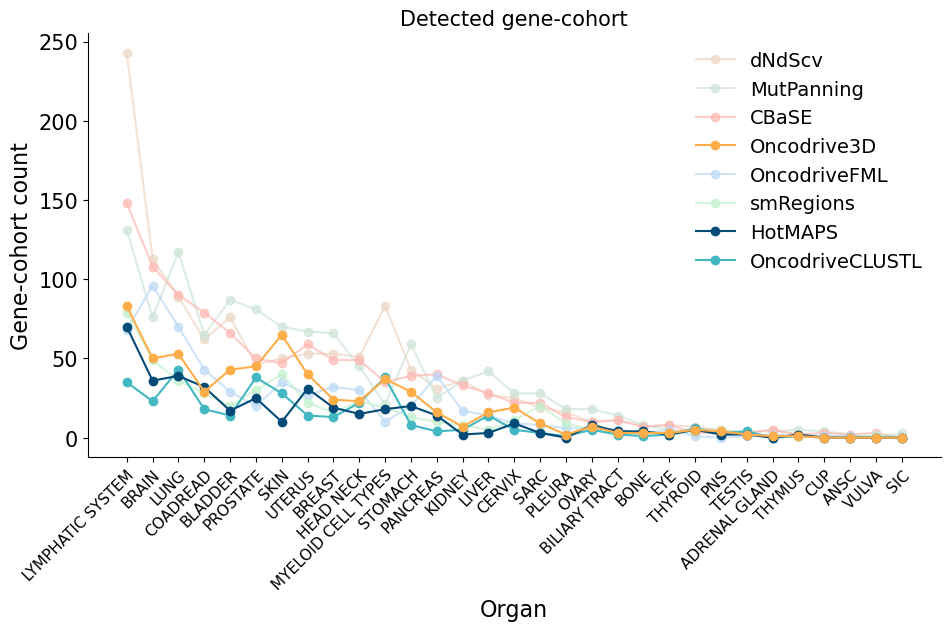

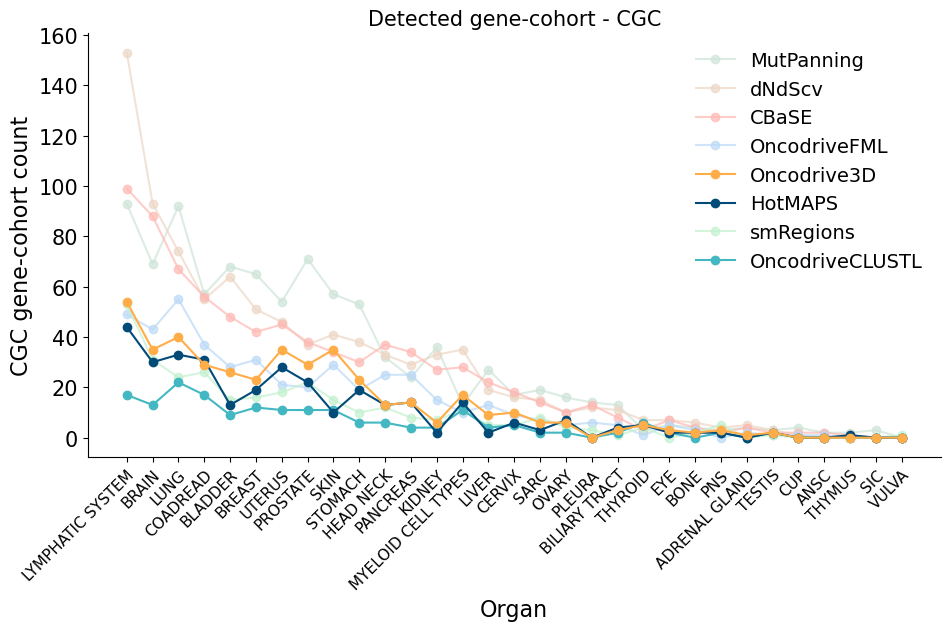

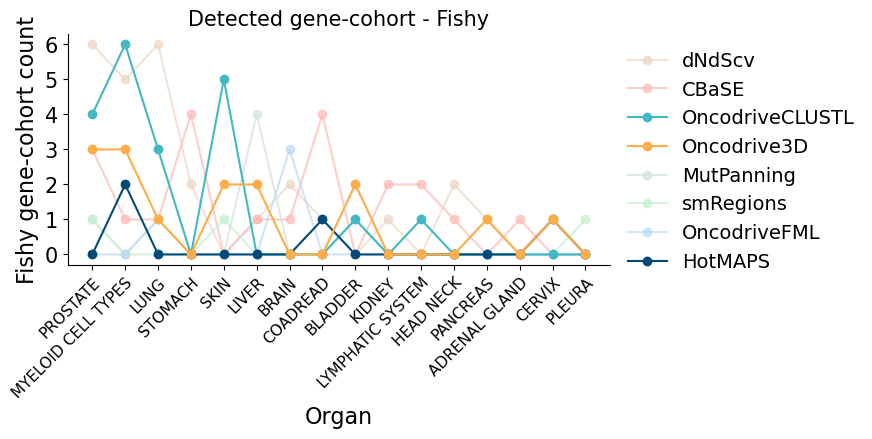

In [86]:
# Organs gene-cohort
# ------------------

df = genetable.copy()
hits_df = get_hits_summary_lst_organs(df, lst_methods, cohort_df, unknown=False, unique=False)
hits_df.Organ = hits_df.Organ.str.replace("_", " ")
hits_df.Organ = hits_df.Organ.str.replace("LYMPH", "LYMPHATIC SYSTEM")
hits_df.Organ = hits_df.Organ.str.replace("MYELOID", "MYELOID CELL TYPES")
hits_df.Organ = hits_df.Organ.str.replace("SOFT TISSUE", "SARC")

# All gene-cohort
cols = [f"{name}_qval" for name in lst_methods]
plot_hits_summary(hits_df[["Organ"] + cols], names_dic, colors_dic,
                  smooth = False, figsize = (11, 5.5), title = "Detected gene-cohort", 
                  plot_xticks=True, rm_zero_rows=False, 
                  legend_fontsize = 14,
                  ylabel="Gene-cohort count", 
                  target="Organ")

# CGC
cols = [f"{name}_qval_cgc" for name in lst_methods]
plot_hits_summary(hits_df[["Organ"] + cols], names_dic, colors_dic,
                  smooth = False, figsize = (11, 5.5), title = "Detected gene-cohort - CGC", 
                  plot_xticks=True, rm_zero_rows=False, 
                  legend_fontsize = 14,
                  ylabel="CGC gene-cohort count", 
                  target="Organ",
                  filename=f"{figures}/supplementary/s2/s2d.hits_scatter_cgc.png")

# Fishy
cols = [f"{name}_qval_fish" for name in lst_methods]
plot_hits_summary(hits_df[["Organ"] + cols], names_dic, colors_dic,
                  smooth = False, figsize = (7, 3), title = "Detected gene-cohort - Fishy", 
                  plot_xticks=True, rm_zero_rows=True, 
                  legend_fontsize = 14,
                  ylabel="Fishy gene-cohort count", 
                  target="Organ")

100%|██████████| 31/31 [00:03<00:00,  8.81it/s]


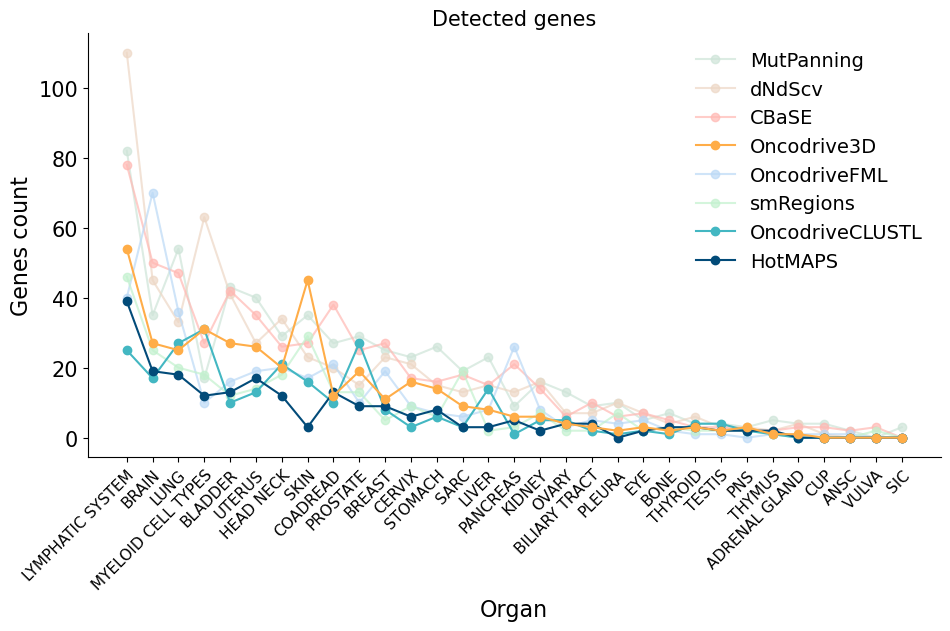

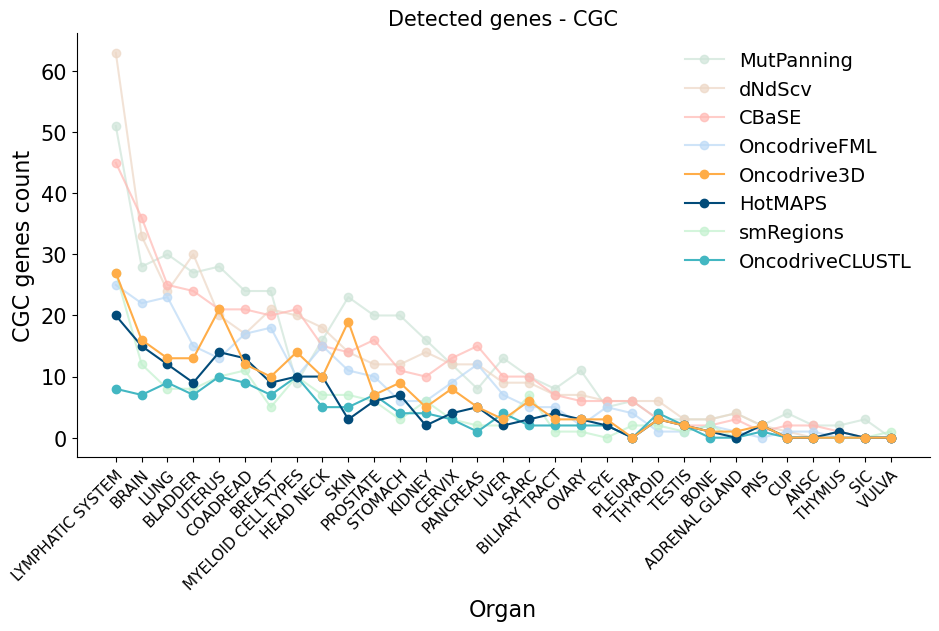

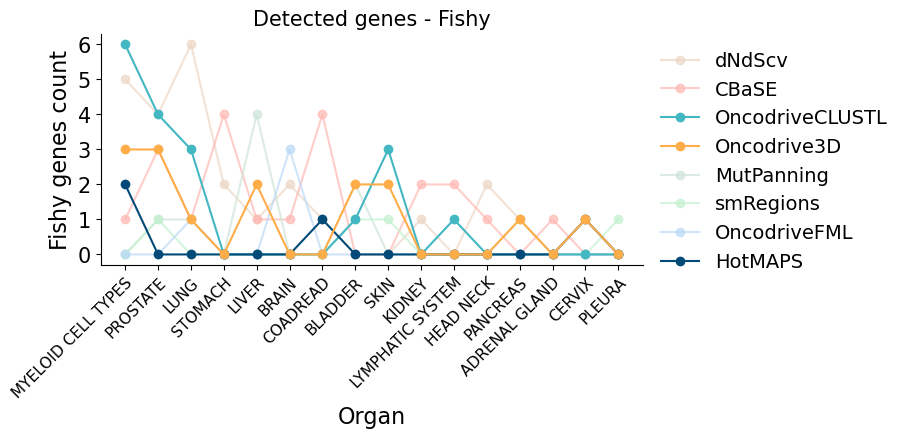

100%|██████████| 31/31 [00:03<00:00,  8.75it/s]


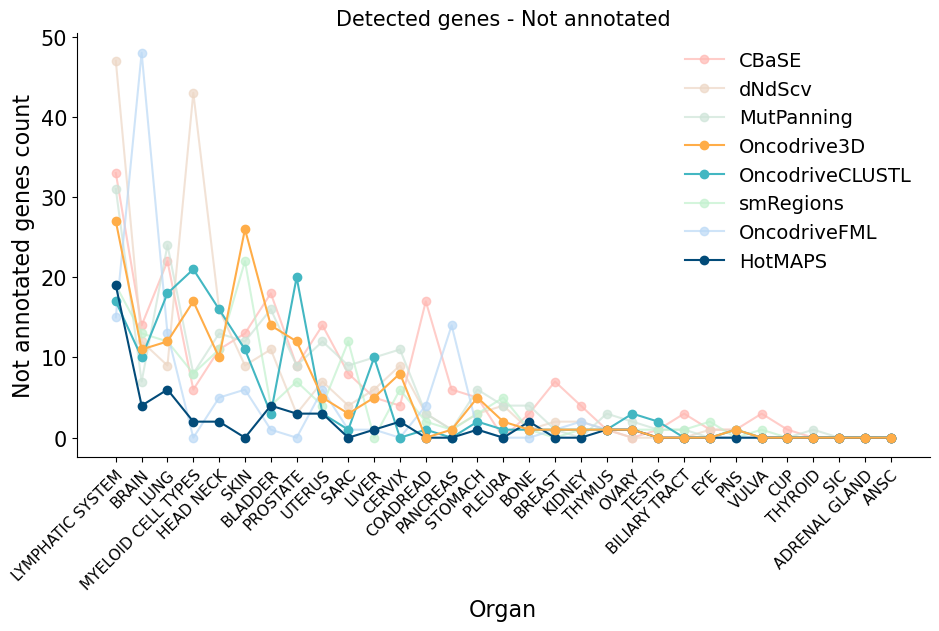

In [87]:
# Organs unique genes
# -------------------

df = genetable.copy()
hits_df = get_hits_summary_lst_organs(df, lst_methods, cohort_df, unknown=False, unique=True)
hits_df.Organ = hits_df.Organ.str.replace("_", " ")
hits_df.Organ = hits_df.Organ.str.replace("LYMPH", "LYMPHATIC SYSTEM")
hits_df.Organ = hits_df.Organ.str.replace("MYELOID", "MYELOID CELL TYPES")
hits_df.Organ = hits_df.Organ.str.replace("SOFT TISSUE", "SARC")

# All gene-cohort
cols = [f"{name}_qval" for name in lst_methods]
plot_hits_summary(hits_df[["Organ"] + cols], names_dic, colors_dic,
                  smooth = False, figsize = (11, 5.5), title = "Detected genes", 
                  plot_xticks=True, rm_zero_rows=False, 
                  legend_fontsize = 14,
                  ylabel="Genes count", 
                  target="Organ")

# CGC
cols = [f"{name}_qval_cgc" for name in lst_methods]
plot_hits_summary(hits_df[["Organ"] + cols], names_dic, colors_dic,
                  smooth = False, figsize = (11, 5.5), title = "Detected genes - CGC", 
                  plot_xticks=True, rm_zero_rows=False, 
                  legend_fontsize = 14,
                  ylabel="CGC genes count", 
                  target="Organ")

# Fishy
cols = [f"{name}_qval_fish" for name in lst_methods]
plot_hits_summary(hits_df[["Organ"] + cols], names_dic, colors_dic,
                  smooth = False, figsize = (7, 3), title = "Detected genes - Fishy", 
                  plot_xticks=True, rm_zero_rows=True, 
                  legend_fontsize = 14,
                  ylabel="Fishy genes count", 
                  target="Organ")


# Not annotated
df = genetable.copy()
hits_df = get_hits_summary_lst_organs(df, lst_methods, cohort_df, unknown=True, unique=True)
hits_df.Organ = hits_df.Organ.str.replace("_", " ")
hits_df.Organ = hits_df.Organ.str.replace("LYMPH", "LYMPHATIC SYSTEM")
hits_df.Organ = hits_df.Organ.str.replace("MYELOID", "MYELOID CELL TYPES")
hits_df.Organ = hits_df.Organ.str.replace("SOFT TISSUE", "SARC")

cols = [f"{name}_qval" for name in lst_methods]
plot_hits_summary(hits_df[["Organ"] + cols], names_dic, colors_dic,
                  smooth = False, figsize = (11, 5.5), title = "Detected genes - Not annotated", 
                  plot_xticks=True, rm_zero_rows=False, 
                  legend_fontsize = 14,
                  ylabel="Not annotated genes count", 
                  target="Organ",
                  filename=f"{figures}/supplementary/s11/s11a.hits_scatter_organ_unique_unknown.png")

### All cohorts

100%|██████████| 214/214 [00:42<00:00,  5.02it/s]


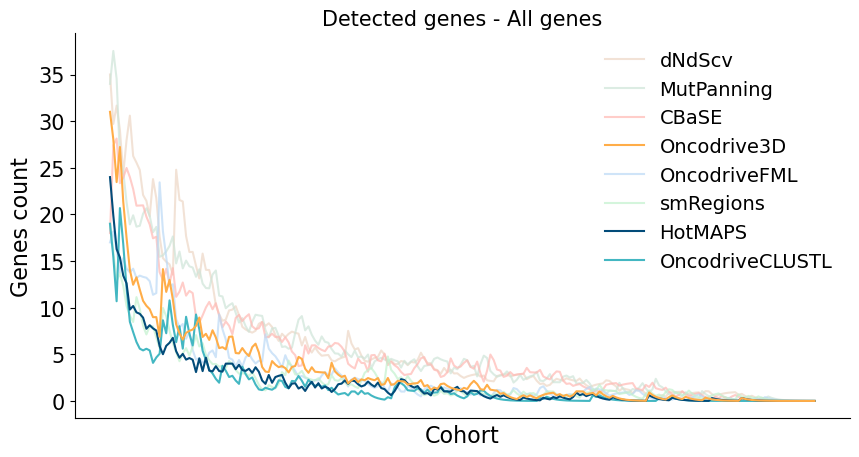

In [88]:
## All cohorts
df = genetable.copy()
hits_df = get_hits_summary_lst_cohorts(df, lst_methods, unknown=False, unique=False)

# All genes

cols = [f"{name}_qval" for name in lst_methods]
plot_hits_summary(hits_df[["Cohort"] + cols], names_dic, colors_dic,
                  smooth = True, figsize = (10, 5), title = "Detected genes - All genes", 
                  plot_xticks=False, rm_zero_rows=False, style="-",
                  legend_fontsize = 14,
                  ylabel="Genes count")

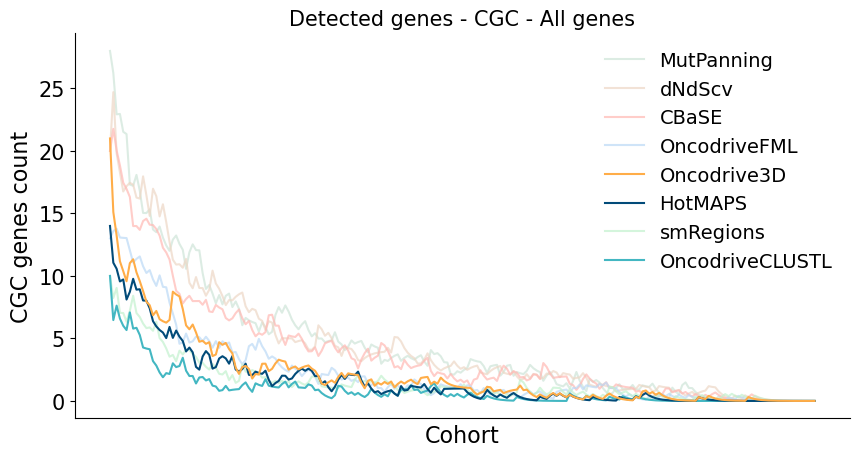

In [89]:
# CGC

cols = [f"{name}_qval_cgc" for name in lst_methods]
plot_hits_summary(hits_df[["Cohort"] + cols], names_dic, colors_dic,
                  smooth = True, figsize = (10, 5), title = "Detected genes - CGC - All genes", 
                  plot_xticks=False, rm_zero_rows=False, style="-",
                  legend_fontsize = 14,
                  ylabel="CGC genes count",
                  filename=f"{figures}/supplementary/s2/s2c.hits_scatter_cgc.png")

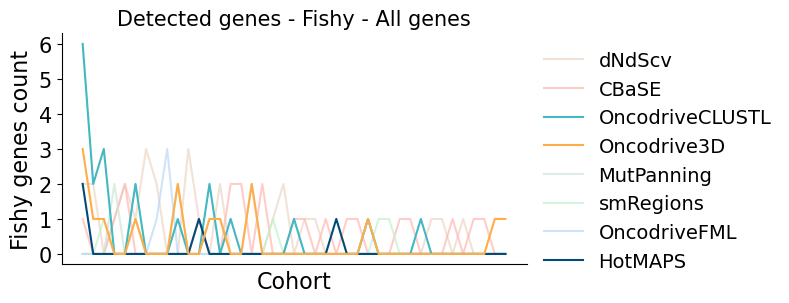

In [90]:
# Fish

cols = [f"{name}_qval_fish" for name in lst_methods]
plot_hits_summary(hits_df[["Cohort"] + cols], names_dic, colors_dic,
                  smooth = False, figsize = (6, 3), title = "Detected genes - Fishy - All genes", 
                  plot_xticks=False, rm_zero_rows=True, style="-",
                  legend_fontsize = 14,
                  ylabel="Fishy genes count")

100%|██████████| 214/214 [00:42<00:00,  4.98it/s]


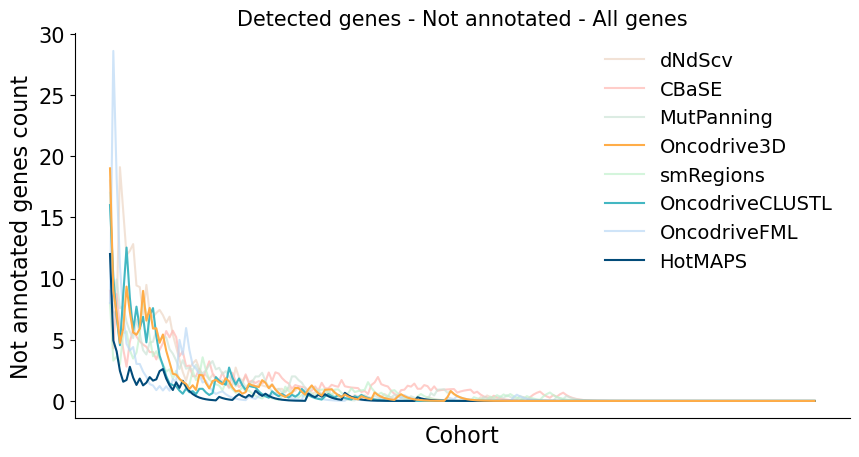

In [91]:
# Not annotated

df = genetable.copy()
hits_df = get_hits_summary_lst_cohorts(df, lst_methods, unknown=True, unique=False)

cols = [f"{name}_qval" for name in lst_methods]
plot_hits_summary(hits_df[["Cohort"] + cols], names_dic, colors_dic,
                  smooth = True, figsize = (10, 5), 
                  title = "Detected genes - Not annotated - All genes", 
                  plot_xticks=False, rm_zero_rows=False, style="-",
                  legend_fontsize = 14,
                  ylabel="Not annotated genes count")